# Policy Gradient 

This Notebook reimplements the basic REINFORCE policy gradient in Pytorch with GPU acceleration.

First it runs Karpathy's numpy implementation to 30K episodes.

Next we convert PyTorch's REINFORCE implementation to play Cartpole to Pong. To prevent GPU memory error, we limit the agent to perform policy gradient update after a fixed number of steps (batch_size=800). 

Karpathy's implementation perform the policy gradient update after a full episode has been played. 

We discover having batch_size=800 results in an inferior agent.


In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import pickle as pickle
import pympler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

# For advanced computer vision
import cv2

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.4


In [2]:
import gc
gc.collect()

11

## Karpathy Basic Policy Gradient "Pong"

The following code uses a basic policy gradient method to train a 2 layer NN to play Pong.

The time needed to train 10 episodes is 13 sec with CPU.

The forward pass takes 4 seconds. So implementing this in PyTorch and using GPU will speed things up by 30%.

In [3]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
  model = pickle.load(open('save.p', 'rb'))
else:
  model = {}
  model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
  model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()

def discount_rewards(r):
  """ take 1D float array of rewards and compute discounted reward """
  discounted_r = np.zeros_like(r)
  running_add = 0
  for t in reversed(range(0, r.size)):
    if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
    running_add = running_add * gamma + r[t]
    discounted_r[t] = running_add
  return discounted_r

def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
  """ backward pass. (eph is array of intermediate hidden states) """
  dW2 = np.dot(eph.T, epdlogp).ravel()
  dh = np.outer(epdlogp, model['W2'])
  dh[eph <= 0] = 0 # backpro prelu
  dW1 = np.dot(dh.T, epx)
  return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
verbose = False
print_every = 20
reward_sum = 0
episode_number = 0
forward_time=0
backward_time=0
other_time = 0

start = time.time()

while episode_number < 30000:
  if render: env.render()

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  t1 = time.time()
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!
  t2 = time.time()
  forward_time += t2-t1

  # record various intermediates (needed later for backprop)
  xs.append(x) # observation
  hs.append(h) # hidden state
  y = 1 if action == 2 else 0 # a "fake label"
  dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
  t5 = time.time()  
  # step the environment and get new measurements
  observation, reward, done, info = env.step(action)
  reward_sum += reward

  t6 = time.time()
  other_time += t6-t5

  drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

  if done: # an episode finished
    episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(xs)
    eph = np.vstack(hs)
    epdlogp = np.vstack(dlogps)
    epr = np.vstack(drs)
    xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
    discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_epr -= np.mean(discounted_epr)
    discounted_epr /= np.std(discounted_epr)

    epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
    
    t3 = time.time()    
    grad = policy_backward(eph, epdlogp)
    t4 = time.time()
    backward_time += t4-t3    
    
    for k in model: 
        grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
    if episode_number % batch_size == 0:
      for k,v in model.items():
        g = grad_buffer[k] # gradient
        rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
        model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
        grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    if episode_number % print_every == 0:     
        print ('Episode %d - reward total was %f. running mean: %f' % (episode_number, reward_sum, running_reward))

    epoch_reward_history.append([reward_sum, running_reward])
    if episode_number % 100 == 0: pickle.dump(model, open('save.p', 'wb'))
    reward_sum = 0
    observation = env.reset() # reset env
    prev_x = None

  if reward != 0 and verbose: # Pong has either +1 or -1 reward exactly when game ends.
    print (('ep %d: game finished, reward: %f' % (episode_number, reward)) + ('' if reward == -1 else ' !!!!!!!!'))
    
end = time.time()
print ("Time to complete", end-start)
print ("Time to forward pass", forward_time)
print ("Time to backward pass", backward_time)
print ("Time to other stuffs", other_time)

Episode 20 - reward total was -21.000000. running mean: -19.191718
Episode 40 - reward total was -21.000000. running mean: -19.493028
Episode 60 - reward total was -18.000000. running mean: -19.626406
Episode 80 - reward total was -21.000000. running mean: -19.838562
Episode 100 - reward total was -21.000000. running mean: -19.924114
Episode 120 - reward total was -20.000000. running mean: -19.949014
Episode 140 - reward total was -21.000000. running mean: -20.014424
Episode 160 - reward total was -19.000000. running mean: -20.058313
Episode 180 - reward total was -19.000000. running mean: -20.099129
Episode 200 - reward total was -21.000000. running mean: -20.123343
Episode 220 - reward total was -19.000000. running mean: -20.155702
Episode 240 - reward total was -20.000000. running mean: -20.099806
Episode 260 - reward total was -20.000000. running mean: -20.106200
Episode 280 - reward total was -18.000000. running mean: -20.056696
Episode 300 - reward total was -20.000000. running m

Episode 2420 - reward total was -10.000000. running mean: -8.896116
Episode 2440 - reward total was -5.000000. running mean: -8.971274
Episode 2460 - reward total was -2.000000. running mean: -8.661507
Episode 2480 - reward total was -12.000000. running mean: -8.344705
Episode 2500 - reward total was -6.000000. running mean: -8.619337
Episode 2520 - reward total was -7.000000. running mean: -8.339132
Episode 2540 - reward total was -6.000000. running mean: -8.245988
Episode 2560 - reward total was -9.000000. running mean: -8.425460
Episode 2580 - reward total was -5.000000. running mean: -8.396669
Episode 2600 - reward total was -13.000000. running mean: -8.425841
Episode 2620 - reward total was -7.000000. running mean: -8.569912
Episode 2640 - reward total was -8.000000. running mean: -8.723125
Episode 2660 - reward total was -6.000000. running mean: -8.703735
Episode 2680 - reward total was -11.000000. running mean: -8.594523
Episode 2700 - reward total was -8.000000. running mean: -

Episode 4880 - reward total was -9.000000. running mean: -1.528595
Episode 4900 - reward total was -5.000000. running mean: -1.343896
Episode 4920 - reward total was -7.000000. running mean: -0.996485
Episode 4940 - reward total was -8.000000. running mean: -1.111612
Episode 4960 - reward total was 1.000000. running mean: -1.265229
Episode 4980 - reward total was -7.000000. running mean: -1.045815
Episode 5000 - reward total was -5.000000. running mean: -1.061881
Episode 5020 - reward total was 3.000000. running mean: -1.257994
Episode 5040 - reward total was -9.000000. running mean: -1.389346
Episode 5060 - reward total was -3.000000. running mean: -1.349805
Episode 5080 - reward total was -2.000000. running mean: -1.433629
Episode 5100 - reward total was 2.000000. running mean: -1.661925
Episode 5120 - reward total was 1.000000. running mean: -1.280201
Episode 5140 - reward total was -3.000000. running mean: -1.515424
Episode 5160 - reward total was 10.000000. running mean: -1.142026

Episode 7360 - reward total was -2.000000. running mean: 1.021549
Episode 7380 - reward total was 7.000000. running mean: 0.957802
Episode 7400 - reward total was 6.000000. running mean: 0.652639
Episode 7420 - reward total was 4.000000. running mean: 0.828301
Episode 7440 - reward total was -1.000000. running mean: 0.786229
Episode 7460 - reward total was 3.000000. running mean: 0.919379
Episode 7480 - reward total was 9.000000. running mean: 0.979034
Episode 7500 - reward total was 7.000000. running mean: 1.051321
Episode 7520 - reward total was -4.000000. running mean: 1.054649
Episode 7540 - reward total was -9.000000. running mean: 1.012505
Episode 7560 - reward total was 5.000000. running mean: 0.889050
Episode 7580 - reward total was -6.000000. running mean: 0.725029
Episode 7600 - reward total was -3.000000. running mean: 0.808028
Episode 7620 - reward total was -3.000000. running mean: 0.898905
Episode 7640 - reward total was 1.000000. running mean: 0.467478
Episode 7660 - rew

Episode 9860 - reward total was 3.000000. running mean: 1.390462
Episode 9880 - reward total was -3.000000. running mean: 0.977109
Episode 9900 - reward total was -5.000000. running mean: 1.321031
Episode 9920 - reward total was 2.000000. running mean: 1.395496
Episode 9940 - reward total was -10.000000. running mean: 1.341524
Episode 9960 - reward total was 4.000000. running mean: 1.030265
Episode 9980 - reward total was 6.000000. running mean: 1.106101
Episode 10000 - reward total was 4.000000. running mean: 1.282660
Episode 10020 - reward total was -1.000000. running mean: 1.020208
Episode 10040 - reward total was 12.000000. running mean: 1.372560
Episode 10060 - reward total was 7.000000. running mean: 1.145326
Episode 10080 - reward total was -3.000000. running mean: 0.739030
Episode 10100 - reward total was -12.000000. running mean: 1.148308
Episode 10120 - reward total was 8.000000. running mean: 1.077477
Episode 10140 - reward total was -5.000000. running mean: 1.017323
Episode

Episode 12340 - reward total was 1.000000. running mean: 1.307019
Episode 12360 - reward total was 5.000000. running mean: 1.404839
Episode 12380 - reward total was 1.000000. running mean: 1.491060
Episode 12400 - reward total was 7.000000. running mean: 1.153945
Episode 12420 - reward total was -4.000000. running mean: 0.813916
Episode 12440 - reward total was -1.000000. running mean: 1.036089
Episode 12460 - reward total was 9.000000. running mean: 1.134736
Episode 12480 - reward total was 10.000000. running mean: 1.304625
Episode 12500 - reward total was 1.000000. running mean: 1.317808
Episode 12520 - reward total was 11.000000. running mean: 1.168476
Episode 12540 - reward total was -7.000000. running mean: 0.899210
Episode 12560 - reward total was 1.000000. running mean: 1.210105
Episode 12580 - reward total was -5.000000. running mean: 1.207233
Episode 12600 - reward total was 6.000000. running mean: 1.131764
Episode 12620 - reward total was 4.000000. running mean: 0.837093
Epis

Episode 14820 - reward total was 4.000000. running mean: 3.030129
Episode 14840 - reward total was 9.000000. running mean: 3.087029
Episode 14860 - reward total was 8.000000. running mean: 3.234592
Episode 14880 - reward total was -2.000000. running mean: 2.927183
Episode 14900 - reward total was 11.000000. running mean: 3.198405
Episode 14920 - reward total was 7.000000. running mean: 3.198064
Episode 14940 - reward total was -3.000000. running mean: 2.788381
Episode 14960 - reward total was 5.000000. running mean: 2.509967
Episode 14980 - reward total was 6.000000. running mean: 2.239266
Episode 15000 - reward total was -3.000000. running mean: 2.305704
Episode 15020 - reward total was 7.000000. running mean: 2.226748
Episode 15040 - reward total was -3.000000. running mean: 1.894303
Episode 15060 - reward total was 10.000000. running mean: 1.532444
Episode 15080 - reward total was 10.000000. running mean: 1.926986
Episode 15100 - reward total was 4.000000. running mean: 1.807844
Epi

Episode 17300 - reward total was 9.000000. running mean: 4.612236
Episode 17320 - reward total was 10.000000. running mean: 4.415685
Episode 17340 - reward total was 2.000000. running mean: 4.728732
Episode 17360 - reward total was 10.000000. running mean: 4.686101
Episode 17380 - reward total was -11.000000. running mean: 4.378700
Episode 17400 - reward total was 2.000000. running mean: 4.359431
Episode 17420 - reward total was 3.000000. running mean: 4.326614
Episode 17440 - reward total was 4.000000. running mean: 4.421106
Episode 17460 - reward total was 4.000000. running mean: 4.053206
Episode 17480 - reward total was 3.000000. running mean: 4.347112
Episode 17500 - reward total was 2.000000. running mean: 4.049507
Episode 17520 - reward total was 8.000000. running mean: 4.266501
Episode 17540 - reward total was -6.000000. running mean: 4.167859
Episode 17560 - reward total was 6.000000. running mean: 4.715632
Episode 17580 - reward total was 15.000000. running mean: 4.646333
Epis

Episode 19780 - reward total was 9.000000. running mean: 5.919682
Episode 19800 - reward total was 13.000000. running mean: 5.762293
Episode 19820 - reward total was 15.000000. running mean: 5.872688
Episode 19840 - reward total was 15.000000. running mean: 5.898519
Episode 19860 - reward total was 8.000000. running mean: 6.116461
Episode 19880 - reward total was 2.000000. running mean: 6.352028
Episode 19900 - reward total was 9.000000. running mean: 6.526527
Episode 19920 - reward total was 7.000000. running mean: 6.500183
Episode 19940 - reward total was -3.000000. running mean: 6.151241
Episode 19960 - reward total was 3.000000. running mean: 6.100042
Episode 19980 - reward total was 7.000000. running mean: 5.776111
Episode 20000 - reward total was -4.000000. running mean: 5.936390
Episode 20020 - reward total was -7.000000. running mean: 5.779199
Episode 20040 - reward total was 11.000000. running mean: 5.744955
Episode 20060 - reward total was 8.000000. running mean: 5.929773
Epi

Episode 22260 - reward total was 7.000000. running mean: 7.151897
Episode 22280 - reward total was -3.000000. running mean: 6.488826
Episode 22300 - reward total was 7.000000. running mean: 6.148801
Episode 22320 - reward total was 3.000000. running mean: 6.817327
Episode 22340 - reward total was 11.000000. running mean: 6.825757
Episode 22360 - reward total was 15.000000. running mean: 7.035366
Episode 22380 - reward total was 9.000000. running mean: 6.624536
Episode 22400 - reward total was 10.000000. running mean: 6.851930
Episode 22420 - reward total was 5.000000. running mean: 7.073035
Episode 22440 - reward total was 8.000000. running mean: 7.105603
Episode 22460 - reward total was -7.000000. running mean: 6.956111
Episode 22480 - reward total was 1.000000. running mean: 7.209579
Episode 22500 - reward total was 11.000000. running mean: 7.577972
Episode 22520 - reward total was 15.000000. running mean: 7.575959
Episode 22540 - reward total was 9.000000. running mean: 7.590207
Epi

Episode 24740 - reward total was 4.000000. running mean: 8.268516
Episode 24760 - reward total was 12.000000. running mean: 7.935447
Episode 24780 - reward total was 4.000000. running mean: 7.794722
Episode 24800 - reward total was 18.000000. running mean: 7.913551
Episode 24820 - reward total was -1.000000. running mean: 7.781767
Episode 24840 - reward total was 12.000000. running mean: 7.858520
Episode 24860 - reward total was 9.000000. running mean: 8.130384
Episode 24880 - reward total was 7.000000. running mean: 8.258623
Episode 24900 - reward total was 9.000000. running mean: 8.289880
Episode 24920 - reward total was 12.000000. running mean: 8.231185
Episode 24940 - reward total was 13.000000. running mean: 8.225268
Episode 24960 - reward total was 8.000000. running mean: 8.118598
Episode 24980 - reward total was 9.000000. running mean: 7.749597
Episode 25000 - reward total was 14.000000. running mean: 7.751510
Episode 25020 - reward total was 7.000000. running mean: 7.637833
Epi

Episode 27220 - reward total was 7.000000. running mean: 7.722048
Episode 27240 - reward total was 11.000000. running mean: 7.451897
Episode 27260 - reward total was 9.000000. running mean: 7.826119
Episode 27280 - reward total was 14.000000. running mean: 7.960232
Episode 27300 - reward total was 7.000000. running mean: 8.051526
Episode 27320 - reward total was 9.000000. running mean: 8.397081
Episode 27340 - reward total was -3.000000. running mean: 8.284241
Episode 27360 - reward total was 12.000000. running mean: 8.557420
Episode 27380 - reward total was 6.000000. running mean: 8.758837
Episode 27400 - reward total was 9.000000. running mean: 8.570707
Episode 27420 - reward total was 8.000000. running mean: 8.591696
Episode 27440 - reward total was 6.000000. running mean: 8.294094
Episode 27460 - reward total was 1.000000. running mean: 8.499394
Episode 27480 - reward total was 4.000000. running mean: 8.518512
Episode 27500 - reward total was 16.000000. running mean: 8.510380
Episo

Episode 29700 - reward total was 13.000000. running mean: 9.633814
Episode 29720 - reward total was 9.000000. running mean: 9.508944
Episode 29740 - reward total was 9.000000. running mean: 9.248202
Episode 29760 - reward total was 14.000000. running mean: 9.492634
Episode 29780 - reward total was 16.000000. running mean: 9.436779
Episode 29800 - reward total was 14.000000. running mean: 9.355317
Episode 29820 - reward total was 15.000000. running mean: 9.536183
Episode 29840 - reward total was 14.000000. running mean: 9.722465
Episode 29860 - reward total was 11.000000. running mean: 9.657248
Episode 29880 - reward total was 15.000000. running mean: 9.448781
Episode 29900 - reward total was 8.000000. running mean: 9.572944
Episode 29920 - reward total was 3.000000. running mean: 9.233858
Episode 29940 - reward total was 1.000000. running mean: 9.338660
Episode 29960 - reward total was 13.000000. running mean: 9.576754
Episode 29980 - reward total was 8.000000. running mean: 9.552465
E

## Display and Save Results

These training takes a long time. We need to save the following:  
(1) Reward history and Plot  
(2) Parameters at different point in training  

In [6]:
pickle.dump(epoch_reward_history, open('reward_history-pg-numpy-30000ep-lr-1e-3.p', 'wb'))

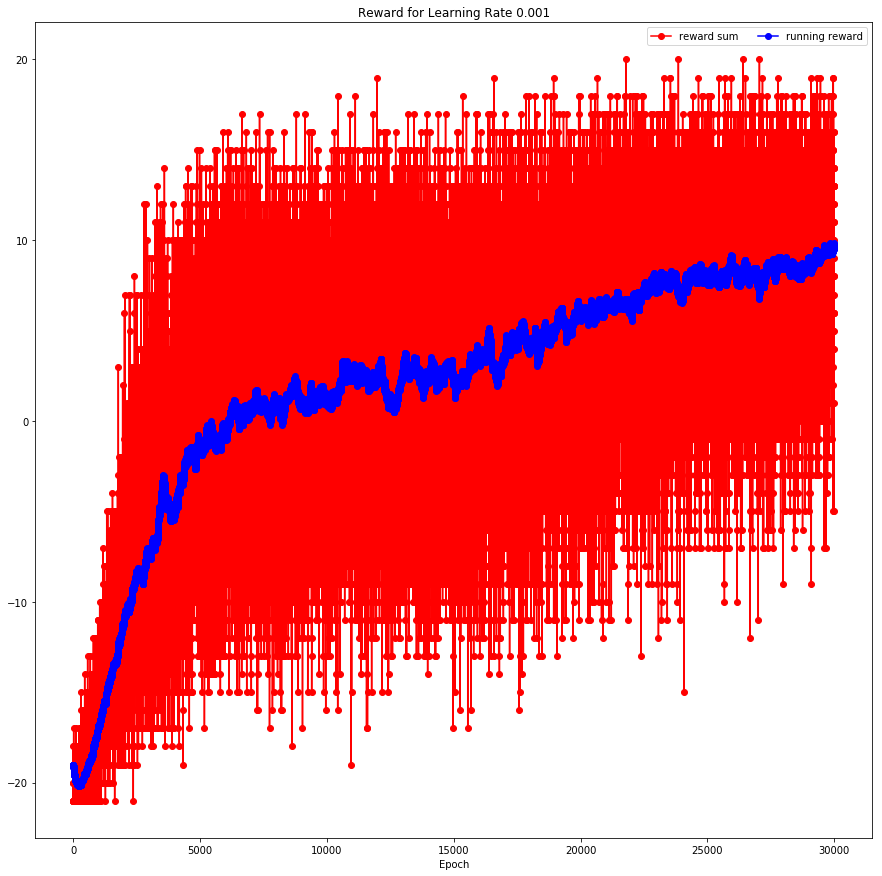

In [4]:
history = np.array(epoch_reward_history)

# Plot out the accuracies
plt.title('Reward for Learning Rate '+str(learning_rate))
plt.xlabel('Epoch')
plt.plot(history[:,0], '-ro', label="reward sum")
plt.plot(history[:,1], '-bo', label="running reward")
plt.legend(loc='best', ncol=4)

 
plt.gcf().set_size_inches(15, 15)
plt.show()


## Load Parameters and Let's Play

The code below loads parameters from save.p into the pg-pong agent and renders 1 episode. The agent and the game will play til one of them reach 21 points.

In [2]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle as pickle
import gym
import time

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?

learning_rate  = 1e-3
epoch_reward_history=[]
    
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid

model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x): 
  return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
  """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
  I = I[35:195] # crop
  I = I[::2,::2,0] # downsample by factor of 2
  I[I == 144] = 0 # erase background (background type 1)
  I[I == 109] = 0 # erase background (background type 2)
  I[I != 0] = 1 # everything else (paddles, ball) just set to 1
  return I.astype(np.float).ravel()


def policy_forward(x):
  h = np.dot(model['W1'], x)
  h[h<0] = 0 # ReLU nonlinearity
  logp = np.dot(model['W2'], h)
  p = sigmoid(logp)
  return p, h # return probability of taking action 2, and hidden state

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame

reward_sum = 0

t = 0

while t < 30000:  # make sure there is no infinite loop
  t += 1
  env.render()
    
  time.sleep(0.01)  # slow it down for us to observe

  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
  aprob, h = policy_forward(x)
  action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # step the environment and get new measurements
  observation, reward, done, _ = env.step(action)
  reward_sum += reward

  if done: # an episode finished
    break
    
env.close()
print (reward_sum)

    

13.0


## What the NN is learning

We display 20 of the W1 matrix columns which is elementwise multiplied against an image vector.

W1 is essentially doing pattern matching on:

1. The trajecory of the puck
2. Position of the 2 paddles

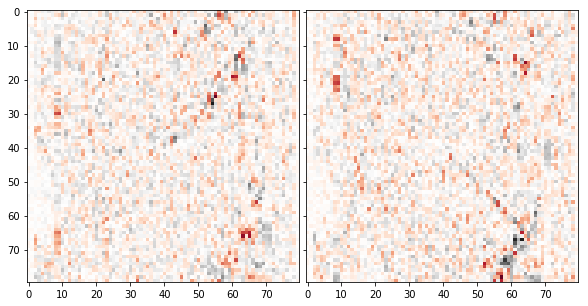

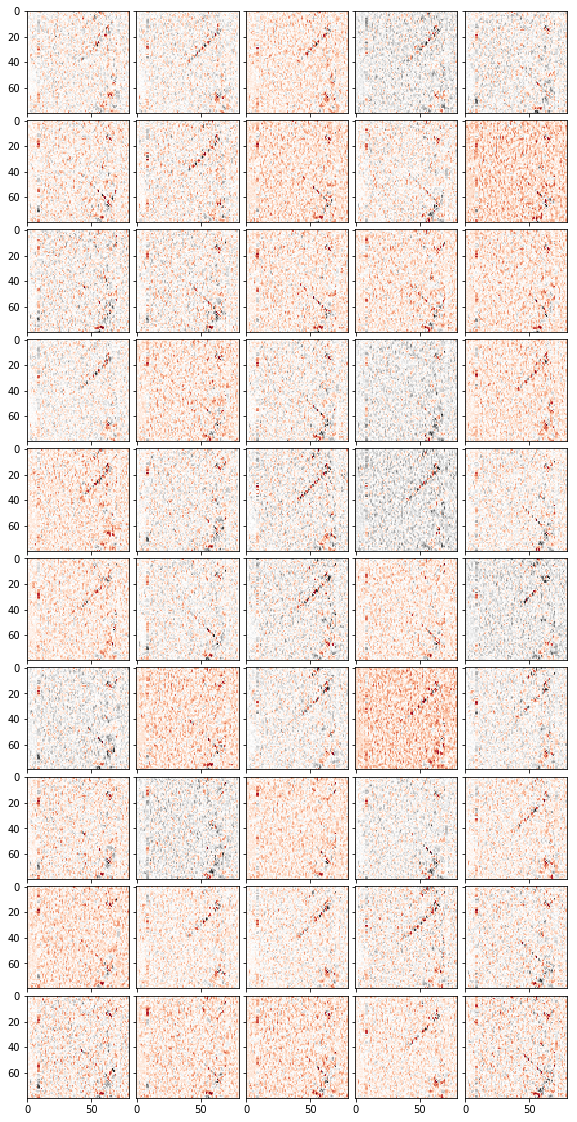

In [50]:
from mpl_toolkits.axes_grid1 import ImageGrid

# model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (10., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = model['W1'][0,:].reshape(80,80)
grid[0].imshow(image, cmap='RdGy')
image = model['W1'][8,:].reshape(80,80)
grid[1].imshow(image, cmap='RdGy')

plt.show()


fig = plt.figure(1, (12., 20.))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(50):
    # The AxesGrid object work as a list of axes.
    image = model['W1'][i,:].reshape(80,80)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

## Implement PyTorch REINFORCE-Pong

We will now reimplement the REINFORCE-Pong in PyTorch:

* Run time episode is 2.4sec without GPU acceleration.  
* Run time episode is 0.9sec with GPU acceleration.  

We hit out of memory error after 75 episodes because PyTorch does not manage GPU memory well with this unconventional training.  

1000-1500 policy.forward() is run, and the log_prop and rewards are batched into a list, summed to a scalar policy_loss and then a backward() is called on policy_loss, instead of policy.  



In [7]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=10
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)


def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::4,::4,0] # downsample by factor of 4
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_episode():
    """ 
    Based on REINFORCE, policy gradient is calculated at the end of an episode.
    It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del rewards, policy_loss  # start deleting stuffs to address memory leak
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
prev_x = None
running_reward = -21

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 1600 (80x80) 1D float vector
        cur_x = prepro(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        #state = torch.from_numpy(state).float().unsqueeze(0)
    
        # Use Policy to generate probability for action
        # probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

        # Sample action stochastically    
        # m = Categorical(probs)
        # action = m.sample()
        
        # Store log_prob (score function) into a list for calculating policy gradient    
        # policy.saved_log_probs.append(m.log_prob(action))
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        # break if episode is done
        if done:
            break
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    
    # Calculate policy gradient and update Policy 
    finish_episode()
    
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # track memory usage every 100 episodes
    if i_episode % 2000 == 0:
         summary.print_(summary.summarize(muppy.get_objects()))
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)

Episode 0	Last Reward: -21.00	Running Reward: -21.00
                                         types |   # objects |   total size
============================================== | =========== | ============
                                   <class 'str |       75599 |     10.88 MB
                                  <class 'dict |       14877 |      5.98 MB
                                  <class 'type |        2894 |      2.93 MB
                                  <class 'code |       20499 |      2.83 MB
                                  <class 'list |        7538 |    952.26 KB
                                   <class 'set |        2085 |    887.59 KB
                                 <class 'tuple |       10849 |    722.59 KB
                     <class 'method_descriptor |        7050 |    495.70 KB
                               <class 'weakref |        5400 |    421.88 KB
  <class 'torch.autograd.function.FunctionMeta |         265 |    273.28 KB
            <class 'torch._thnn.uti

Episode 1260	Last Reward: -16.00	Running Reward: -16.33
Episode 1270	Last Reward: -12.00	Running Reward: -16.26
Episode 1280	Last Reward: -17.00	Running Reward: -16.27


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/generic/THCStorage.cu:58

## Implement PyTorch REINFORCE-Pong (Version 2)

We will now reimplement the REINFORCE-Pong in PyTorch:

* Run time episode is 0.7sec with GPU acceleration.  

We first tried to downsample the Pong image (80x80 to 40x40) and the number of iteration run increases from 75 to 1000+. But we still encounter GPU out of memory error.

Next we limit the number of steps per episode to 800 (instead of allowing the game to play to end of episodes). There is no more GPU out of memory error, but the training curve flattens 

In [17]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=10
batch_size = 800
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)


def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::4,::4,0] # downsample by factor of 4
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del rewards, policy_loss  # start deleting stuffs to address memory leak
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
prev_x = None
running_reward = -15

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 1600 (80x80) 1D float vector
        cur_x = prepro(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        if done or t > batch_size:
            break
        

    # Calculate policy gradient and update Policy 
    finish_batch()
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # track memory usage every 100 episodes
    if i_episode % 2000 == 0:
         summary.print_(summary.summarize(muppy.get_objects()))
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)

Episode 0	Last Reward: -14.00	Running Reward: -14.99
                                         types |   # objects |   total size
============================================== | =========== | ============
                                   <class 'str |       88581 |     11.92 MB
                                  <class 'dict |       15012 |      6.00 MB
                                  <class 'type |        2897 |      2.97 MB
                                  <class 'code |       20518 |      2.83 MB
                                  <class 'list |       21230 |      2.18 MB
                                   <class 'set |        2135 |    900.03 KB
                                 <class 'tuple |       11019 |    733.38 KB
                     <class 'method_descriptor |        7050 |    495.70 KB
                               <class 'weakref |        5474 |    427.66 KB
                                   <class 'int |        9673 |    285.75 KB
  <class 'torch.autograd.function.F

Episode 1280	Last Reward: -12.00	Running Reward: -8.30
Episode 1290	Last Reward: -5.00	Running Reward: -8.17
Episode 1300	Last Reward: -5.00	Running Reward: -8.14
Episode 1310	Last Reward: -7.00	Running Reward: -8.03
Episode 1320	Last Reward: -7.00	Running Reward: -7.99
Episode 1330	Last Reward: -11.00	Running Reward: -8.00
Episode 1340	Last Reward: -7.00	Running Reward: -7.92
Episode 1350	Last Reward: -4.00	Running Reward: -7.84
Episode 1360	Last Reward: -7.00	Running Reward: -7.89
Episode 1370	Last Reward: -9.00	Running Reward: -7.81
Episode 1380	Last Reward: -7.00	Running Reward: -7.68
Episode 1390	Last Reward: -10.00	Running Reward: -7.76
Episode 1400	Last Reward: -7.00	Running Reward: -7.69
Episode 1410	Last Reward: -7.00	Running Reward: -7.66
Episode 1420	Last Reward: -9.00	Running Reward: -7.66
Episode 1430	Last Reward: -9.00	Running Reward: -7.61
Episode 1440	Last Reward: -7.00	Running Reward: -7.51
Episode 1450	Last Reward: -11.00	Running Reward: -7.54
Episode 1460	Last Reward

Episode 2560	Last Reward: 0.00	Running Reward: -3.25
Episode 2570	Last Reward: -5.00	Running Reward: -3.28
Episode 2580	Last Reward: -1.00	Running Reward: -3.26
Episode 2590	Last Reward: -6.00	Running Reward: -3.32
Episode 2600	Last Reward: -2.00	Running Reward: -3.34
Episode 2610	Last Reward: -4.00	Running Reward: -3.31
Episode 2620	Last Reward: -3.00	Running Reward: -3.29
Episode 2630	Last Reward: -2.00	Running Reward: -3.30
Episode 2640	Last Reward: -5.00	Running Reward: -3.33
Episode 2650	Last Reward: -5.00	Running Reward: -3.30
Episode 2660	Last Reward: -5.00	Running Reward: -3.31
Episode 2670	Last Reward: -4.00	Running Reward: -3.31
Episode 2680	Last Reward: -3.00	Running Reward: -3.28
Episode 2690	Last Reward: -6.00	Running Reward: -3.31
Episode 2700	Last Reward: -2.00	Running Reward: -3.33
Episode 2710	Last Reward: -3.00	Running Reward: -3.37
Episode 2720	Last Reward: -9.00	Running Reward: -3.46
Episode 2730	Last Reward: -9.00	Running Reward: -3.50
Episode 2740	Last Reward: -6.

Episode 4010	Last Reward: -1.00	Running Reward: -2.08
Episode 4020	Last Reward: -3.00	Running Reward: -2.16
Episode 4030	Last Reward: 0.00	Running Reward: -2.13
Episode 4040	Last Reward: -4.00	Running Reward: -2.07
Episode 4050	Last Reward: 0.00	Running Reward: -2.04
Episode 4060	Last Reward: -5.00	Running Reward: -2.06
Episode 4070	Last Reward: -3.00	Running Reward: -2.00
Episode 4080	Last Reward: -2.00	Running Reward: -1.89
Episode 4090	Last Reward: 1.00	Running Reward: -1.81
Episode 4100	Last Reward: 2.00	Running Reward: -1.89
Episode 4110	Last Reward: 3.00	Running Reward: -1.79
Episode 4120	Last Reward: -6.00	Running Reward: -1.87
Episode 4130	Last Reward: -1.00	Running Reward: -1.93
Episode 4140	Last Reward: -4.00	Running Reward: -1.94
Episode 4150	Last Reward: -5.00	Running Reward: -2.02
Episode 4160	Last Reward: 0.00	Running Reward: -1.93
Episode 4170	Last Reward: -4.00	Running Reward: -1.94
Episode 4180	Last Reward: 2.00	Running Reward: -1.95
Episode 4190	Last Reward: -1.00	Run

Episode 5540	Last Reward: -1.00	Running Reward: -1.46
Episode 5550	Last Reward: -2.00	Running Reward: -1.39
Episode 5560	Last Reward: -4.00	Running Reward: -1.46
Episode 5570	Last Reward: -1.00	Running Reward: -1.51
Episode 5580	Last Reward: -4.00	Running Reward: -1.50
Episode 5590	Last Reward: -3.00	Running Reward: -1.56
Episode 5600	Last Reward: -3.00	Running Reward: -1.60
Episode 5610	Last Reward: 0.00	Running Reward: -1.66
Episode 5620	Last Reward: -1.00	Running Reward: -1.74
Episode 5630	Last Reward: 0.00	Running Reward: -1.72
Episode 5640	Last Reward: -1.00	Running Reward: -1.76
Episode 5650	Last Reward: -1.00	Running Reward: -1.65
Episode 5660	Last Reward: 2.00	Running Reward: -1.62
Episode 5670	Last Reward: 0.00	Running Reward: -1.59
Episode 5680	Last Reward: -5.00	Running Reward: -1.66
Episode 5690	Last Reward: -3.00	Running Reward: -1.57
Episode 5700	Last Reward: -5.00	Running Reward: -1.70
Episode 5710	Last Reward: -2.00	Running Reward: -1.68
Episode 5720	Last Reward: -2.00	

Episode 6830	Last Reward: 1.00	Running Reward: -1.23
Episode 6840	Last Reward: 0.00	Running Reward: -1.13
Episode 6850	Last Reward: -2.00	Running Reward: -1.13
Episode 6860	Last Reward: -2.00	Running Reward: -1.08
Episode 6870	Last Reward: -2.00	Running Reward: -1.05
Episode 6880	Last Reward: 0.00	Running Reward: -1.14
Episode 6890	Last Reward: -1.00	Running Reward: -1.14
Episode 6900	Last Reward: 2.00	Running Reward: -1.19
Episode 6910	Last Reward: -2.00	Running Reward: -1.10
Episode 6920	Last Reward: -3.00	Running Reward: -1.05
Episode 6930	Last Reward: -2.00	Running Reward: -1.13
Episode 6940	Last Reward: -4.00	Running Reward: -1.15
Episode 6950	Last Reward: 2.00	Running Reward: -1.09
Episode 6960	Last Reward: -3.00	Running Reward: -1.05
Episode 6970	Last Reward: -4.00	Running Reward: -1.17
Episode 6980	Last Reward: 0.00	Running Reward: -1.27
Episode 6990	Last Reward: -1.00	Running Reward: -1.26
Episode 7000	Last Reward: -4.00	Running Reward: -1.35
Episode 7010	Last Reward: -1.00	Ru

Episode 8120	Last Reward: 0.00	Running Reward: -1.24
Episode 8130	Last Reward: -4.00	Running Reward: -1.34
Episode 8140	Last Reward: 0.00	Running Reward: -1.27
Episode 8150	Last Reward: -3.00	Running Reward: -1.26
Episode 8160	Last Reward: -3.00	Running Reward: -1.31
Episode 8170	Last Reward: 0.00	Running Reward: -1.35
Episode 8180	Last Reward: -5.00	Running Reward: -1.42
Episode 8190	Last Reward: -5.00	Running Reward: -1.49
Episode 8200	Last Reward: -2.00	Running Reward: -1.49
Episode 8210	Last Reward: -1.00	Running Reward: -1.52
Episode 8220	Last Reward: 0.00	Running Reward: -1.46
Episode 8230	Last Reward: 0.00	Running Reward: -1.56
Episode 8240	Last Reward: -3.00	Running Reward: -1.55
Episode 8250	Last Reward: -2.00	Running Reward: -1.54
Episode 8260	Last Reward: 1.00	Running Reward: -1.44
Episode 8270	Last Reward: -3.00	Running Reward: -1.44
Episode 8280	Last Reward: -3.00	Running Reward: -1.50
Episode 8290	Last Reward: 0.00	Running Reward: -1.44
Episode 8300	Last Reward: 0.00	Runn

Episode 9650	Last Reward: -3.00	Running Reward: -1.18
Episode 9660	Last Reward: 1.00	Running Reward: -1.15
Episode 9670	Last Reward: -1.00	Running Reward: -1.19
Episode 9680	Last Reward: -3.00	Running Reward: -1.21
Episode 9690	Last Reward: -4.00	Running Reward: -1.30
Episode 9700	Last Reward: 2.00	Running Reward: -1.28
Episode 9710	Last Reward: 0.00	Running Reward: -1.29
Episode 9720	Last Reward: 2.00	Running Reward: -1.29
Episode 9730	Last Reward: -2.00	Running Reward: -1.33
Episode 9740	Last Reward: -3.00	Running Reward: -1.40
Episode 9750	Last Reward: 1.00	Running Reward: -1.39
Episode 9760	Last Reward: 3.00	Running Reward: -1.32
Episode 9770	Last Reward: -2.00	Running Reward: -1.29
Episode 9780	Last Reward: -1.00	Running Reward: -1.18
Episode 9790	Last Reward: 0.00	Running Reward: -1.14
Episode 9800	Last Reward: 1.00	Running Reward: -1.09
Episode 9810	Last Reward: -2.00	Running Reward: -1.19
Episode 9820	Last Reward: 0.00	Running Reward: -1.22
Episode 9830	Last Reward: -1.00	Runni

Episode 10920	Last Reward: -3.00	Running Reward: -1.38
Episode 10930	Last Reward: -6.00	Running Reward: -1.47
Episode 10940	Last Reward: -4.00	Running Reward: -1.51
Episode 10950	Last Reward: -4.00	Running Reward: -1.48
Episode 10960	Last Reward: -3.00	Running Reward: -1.45
Episode 10970	Last Reward: -4.00	Running Reward: -1.40
Episode 10980	Last Reward: -3.00	Running Reward: -1.45
Episode 10990	Last Reward: -2.00	Running Reward: -1.43
Episode 11000	Last Reward: -2.00	Running Reward: -1.48
Episode 11010	Last Reward: 0.00	Running Reward: -1.45
Episode 11020	Last Reward: 0.00	Running Reward: -1.45
Episode 11030	Last Reward: -3.00	Running Reward: -1.49
Episode 11040	Last Reward: -1.00	Running Reward: -1.50
Episode 11050	Last Reward: -1.00	Running Reward: -1.55
Episode 11060	Last Reward: -2.00	Running Reward: -1.65
Episode 11070	Last Reward: 3.00	Running Reward: -1.62
Episode 11080	Last Reward: -3.00	Running Reward: -1.54
Episode 11090	Last Reward: -4.00	Running Reward: -1.69
Episode 11100

Episode 12190	Last Reward: -2.00	Running Reward: -1.79
Episode 12200	Last Reward: -2.00	Running Reward: -1.76
Episode 12210	Last Reward: -5.00	Running Reward: -1.81
Episode 12220	Last Reward: -5.00	Running Reward: -1.70
Episode 12230	Last Reward: -2.00	Running Reward: -1.62
Episode 12240	Last Reward: 3.00	Running Reward: -1.62
Episode 12250	Last Reward: 1.00	Running Reward: -1.63
Episode 12260	Last Reward: 0.00	Running Reward: -1.58
Episode 12270	Last Reward: -2.00	Running Reward: -1.64
Episode 12280	Last Reward: -2.00	Running Reward: -1.57
Episode 12290	Last Reward: -5.00	Running Reward: -1.68
Episode 12300	Last Reward: -1.00	Running Reward: -1.77
Episode 12310	Last Reward: -4.00	Running Reward: -1.67
Episode 12320	Last Reward: -3.00	Running Reward: -1.68
Episode 12330	Last Reward: -1.00	Running Reward: -1.63
Episode 12340	Last Reward: -3.00	Running Reward: -1.57
Episode 12350	Last Reward: -1.00	Running Reward: -1.51
Episode 12360	Last Reward: -1.00	Running Reward: -1.51
Episode 12370

Episode 13690	Last Reward: -3.00	Running Reward: -1.24
Episode 13700	Last Reward: -2.00	Running Reward: -1.38
Episode 13710	Last Reward: -2.00	Running Reward: -1.46
Episode 13720	Last Reward: -2.00	Running Reward: -1.36
Episode 13730	Last Reward: 0.00	Running Reward: -1.22
Episode 13740	Last Reward: -7.00	Running Reward: -1.35
Episode 13750	Last Reward: -3.00	Running Reward: -1.43
Episode 13760	Last Reward: -1.00	Running Reward: -1.47
Episode 13770	Last Reward: 0.00	Running Reward: -1.49
Episode 13780	Last Reward: -3.00	Running Reward: -1.49
Episode 13790	Last Reward: -1.00	Running Reward: -1.39
Episode 13800	Last Reward: 0.00	Running Reward: -1.37
Episode 13810	Last Reward: -2.00	Running Reward: -1.43
Episode 13820	Last Reward: 1.00	Running Reward: -1.45
Episode 13830	Last Reward: -1.00	Running Reward: -1.46
Episode 13840	Last Reward: -4.00	Running Reward: -1.49
Episode 13850	Last Reward: 1.00	Running Reward: -1.47
Episode 13860	Last Reward: 0.00	Running Reward: -1.46
Episode 13870	La

Episode 14960	Last Reward: 2.00	Running Reward: -0.92
Episode 14970	Last Reward: 0.00	Running Reward: -0.86
Episode 14980	Last Reward: -3.00	Running Reward: -0.87
Episode 14990	Last Reward: -2.00	Running Reward: -0.83
Episode 15000	Last Reward: -3.00	Running Reward: -0.94
Episode 15010	Last Reward: -2.00	Running Reward: -0.98
Episode 15020	Last Reward: -3.00	Running Reward: -1.13
Episode 15030	Last Reward: -2.00	Running Reward: -1.12
Episode 15040	Last Reward: -1.00	Running Reward: -1.11
Episode 15050	Last Reward: -2.00	Running Reward: -1.20
Episode 15060	Last Reward: 0.00	Running Reward: -1.04
Episode 15070	Last Reward: -2.00	Running Reward: -1.01
Episode 15080	Last Reward: -1.00	Running Reward: -0.99
Episode 15090	Last Reward: -3.00	Running Reward: -1.06
Episode 15100	Last Reward: -4.00	Running Reward: -1.02
Episode 15110	Last Reward: 0.00	Running Reward: -1.02
Episode 15120	Last Reward: 0.00	Running Reward: -1.09
Episode 15130	Last Reward: -1.00	Running Reward: -1.07
Episode 15140	L

Episode 16230	Last Reward: -1.00	Running Reward: -1.33
Episode 16240	Last Reward: -2.00	Running Reward: -1.30
Episode 16250	Last Reward: -4.00	Running Reward: -1.37
Episode 16260	Last Reward: 1.00	Running Reward: -1.27
Episode 16270	Last Reward: 0.00	Running Reward: -1.23
Episode 16280	Last Reward: 0.00	Running Reward: -1.21
Episode 16290	Last Reward: -3.00	Running Reward: -1.32
Episode 16300	Last Reward: 2.00	Running Reward: -1.30
Episode 16310	Last Reward: -2.00	Running Reward: -1.23
Episode 16320	Last Reward: 1.00	Running Reward: -1.14
Episode 16330	Last Reward: -1.00	Running Reward: -1.09
Episode 16340	Last Reward: -1.00	Running Reward: -1.13
Episode 16350	Last Reward: 0.00	Running Reward: -1.04
Episode 16360	Last Reward: -3.00	Running Reward: -1.13
Episode 16370	Last Reward: -4.00	Running Reward: -1.21
Episode 16380	Last Reward: -1.00	Running Reward: -1.24
Episode 16390	Last Reward: -2.00	Running Reward: -1.27
Episode 16400	Last Reward: 1.00	Running Reward: -1.34
Episode 16410	Las

Episode 17730	Last Reward: 0.00	Running Reward: -1.47
Episode 17740	Last Reward: -1.00	Running Reward: -1.36
Episode 17750	Last Reward: -1.00	Running Reward: -1.33
Episode 17760	Last Reward: -3.00	Running Reward: -1.39
Episode 17770	Last Reward: -1.00	Running Reward: -1.39
Episode 17780	Last Reward: -1.00	Running Reward: -1.44
Episode 17790	Last Reward: 0.00	Running Reward: -1.52
Episode 17800	Last Reward: -3.00	Running Reward: -1.49
Episode 17810	Last Reward: -3.00	Running Reward: -1.52
Episode 17820	Last Reward: 1.00	Running Reward: -1.50
Episode 17830	Last Reward: -6.00	Running Reward: -1.45
Episode 17840	Last Reward: -4.00	Running Reward: -1.57
Episode 17850	Last Reward: -5.00	Running Reward: -1.59
Episode 17860	Last Reward: -3.00	Running Reward: -1.70
Episode 17870	Last Reward: -1.00	Running Reward: -1.74
Episode 17880	Last Reward: -3.00	Running Reward: -1.71
Episode 17890	Last Reward: -1.00	Running Reward: -1.64
Episode 17900	Last Reward: -3.00	Running Reward: -1.67
Episode 17910

Episode 19000	Last Reward: -2.00	Running Reward: -0.95
Episode 19010	Last Reward: -1.00	Running Reward: -1.02
Episode 19020	Last Reward: -3.00	Running Reward: -1.03
Episode 19030	Last Reward: -1.00	Running Reward: -1.02
Episode 19040	Last Reward: -2.00	Running Reward: -1.11
Episode 19050	Last Reward: 2.00	Running Reward: -0.96
Episode 19060	Last Reward: 1.00	Running Reward: -0.99
Episode 19070	Last Reward: -2.00	Running Reward: -0.95
Episode 19080	Last Reward: 2.00	Running Reward: -0.90
Episode 19090	Last Reward: 1.00	Running Reward: -0.93
Episode 19100	Last Reward: -1.00	Running Reward: -0.93
Episode 19110	Last Reward: -4.00	Running Reward: -0.90
Episode 19120	Last Reward: -3.00	Running Reward: -0.90
Episode 19130	Last Reward: 0.00	Running Reward: -0.92
Episode 19140	Last Reward: -4.00	Running Reward: -0.93
Episode 19150	Last Reward: 0.00	Running Reward: -0.95
Episode 19160	Last Reward: 0.00	Running Reward: -0.95
Episode 19170	Last Reward: -2.00	Running Reward: -1.02
Episode 19180	Las

Episode 20270	Last Reward: -1.00	Running Reward: -1.12
Episode 20280	Last Reward: -1.00	Running Reward: -1.08
Episode 20290	Last Reward: -1.00	Running Reward: -1.10
Episode 20300	Last Reward: -4.00	Running Reward: -1.08
Episode 20310	Last Reward: 0.00	Running Reward: -1.07
Episode 20320	Last Reward: -4.00	Running Reward: -0.96
Episode 20330	Last Reward: 1.00	Running Reward: -0.99
Episode 20340	Last Reward: 0.00	Running Reward: -0.95
Episode 20350	Last Reward: -1.00	Running Reward: -0.94
Episode 20360	Last Reward: 0.00	Running Reward: -0.97
Episode 20370	Last Reward: 0.00	Running Reward: -0.93
Episode 20380	Last Reward: -3.00	Running Reward: -1.03
Episode 20390	Last Reward: 0.00	Running Reward: -0.97
Episode 20400	Last Reward: -2.00	Running Reward: -0.98
Episode 20410	Last Reward: -1.00	Running Reward: -1.05
Episode 20420	Last Reward: -2.00	Running Reward: -1.00
Episode 20430	Last Reward: -5.00	Running Reward: -1.04
Episode 20440	Last Reward: -1.00	Running Reward: -1.07
Episode 20450	La

Episode 21780	Last Reward: 1.00	Running Reward: -1.13
Episode 21790	Last Reward: 0.00	Running Reward: -1.09
Episode 21800	Last Reward: -3.00	Running Reward: -1.16
Episode 21810	Last Reward: 0.00	Running Reward: -1.16
Episode 21820	Last Reward: 1.00	Running Reward: -1.14
Episode 21830	Last Reward: 1.00	Running Reward: -1.10
Episode 21840	Last Reward: -4.00	Running Reward: -1.11
Episode 21850	Last Reward: 1.00	Running Reward: -1.03
Episode 21860	Last Reward: -2.00	Running Reward: -1.02
Episode 21870	Last Reward: -1.00	Running Reward: -1.01
Episode 21880	Last Reward: -4.00	Running Reward: -1.05
Episode 21890	Last Reward: 0.00	Running Reward: -1.00
Episode 21900	Last Reward: -1.00	Running Reward: -0.88
Episode 21910	Last Reward: -3.00	Running Reward: -0.94
Episode 21920	Last Reward: 0.00	Running Reward: -0.93
Episode 21930	Last Reward: -2.00	Running Reward: -0.89
Episode 21940	Last Reward: 0.00	Running Reward: -0.86
Episode 21950	Last Reward: -1.00	Running Reward: -0.90
Episode 21960	Last 

Episode 23050	Last Reward: -2.00	Running Reward: -1.10
Episode 23060	Last Reward: -2.00	Running Reward: -1.13
Episode 23070	Last Reward: 5.00	Running Reward: -1.00
Episode 23080	Last Reward: -3.00	Running Reward: -1.05
Episode 23090	Last Reward: -1.00	Running Reward: -1.05
Episode 23100	Last Reward: 0.00	Running Reward: -1.08
Episode 23110	Last Reward: -1.00	Running Reward: -1.11
Episode 23120	Last Reward: 1.00	Running Reward: -1.04
Episode 23130	Last Reward: 0.00	Running Reward: -0.98
Episode 23140	Last Reward: 2.00	Running Reward: -0.86
Episode 23150	Last Reward: 0.00	Running Reward: -0.87
Episode 23160	Last Reward: -4.00	Running Reward: -0.97
Episode 23170	Last Reward: -2.00	Running Reward: -0.93
Episode 23180	Last Reward: 3.00	Running Reward: -0.83
Episode 23190	Last Reward: 1.00	Running Reward: -0.72
Episode 23200	Last Reward: 0.00	Running Reward: -0.75
Episode 23210	Last Reward: 3.00	Running Reward: -0.61
Episode 23220	Last Reward: 1.00	Running Reward: -0.60
Episode 23230	Last Re

Episode 24320	Last Reward: -2.00	Running Reward: -0.77
Episode 24330	Last Reward: 0.00	Running Reward: -0.86
Episode 24340	Last Reward: -1.00	Running Reward: -0.85
Episode 24350	Last Reward: -5.00	Running Reward: -0.90
Episode 24360	Last Reward: 1.00	Running Reward: -0.94
Episode 24370	Last Reward: 0.00	Running Reward: -0.99
Episode 24380	Last Reward: -3.00	Running Reward: -1.00
Episode 24390	Last Reward: -4.00	Running Reward: -0.95
Episode 24400	Last Reward: -3.00	Running Reward: -0.93
Episode 24410	Last Reward: -2.00	Running Reward: -0.99
Episode 24420	Last Reward: 1.00	Running Reward: -0.97
Episode 24430	Last Reward: 1.00	Running Reward: -0.93
Episode 24440	Last Reward: 0.00	Running Reward: -0.90
Episode 24450	Last Reward: -3.00	Running Reward: -1.02
Episode 24460	Last Reward: 0.00	Running Reward: -0.96
Episode 24470	Last Reward: -2.00	Running Reward: -0.91
Episode 24480	Last Reward: -2.00	Running Reward: -0.95
Episode 24490	Last Reward: -2.00	Running Reward: -0.89
Episode 24500	Las

Episode 25820	Last Reward: 0.00	Running Reward: -0.92
Episode 25830	Last Reward: 0.00	Running Reward: -0.93
Episode 25840	Last Reward: 0.00	Running Reward: -0.97
Episode 25850	Last Reward: -2.00	Running Reward: -0.99
Episode 25860	Last Reward: 2.00	Running Reward: -0.96
Episode 25870	Last Reward: 0.00	Running Reward: -0.90
Episode 25880	Last Reward: -4.00	Running Reward: -0.92
Episode 25890	Last Reward: 1.00	Running Reward: -0.90
Episode 25900	Last Reward: -2.00	Running Reward: -0.92
Episode 25910	Last Reward: -1.00	Running Reward: -0.98
Episode 25920	Last Reward: -2.00	Running Reward: -1.01
Episode 25930	Last Reward: 3.00	Running Reward: -0.98
Episode 25940	Last Reward: -2.00	Running Reward: -0.93
Episode 25950	Last Reward: -4.00	Running Reward: -1.03
Episode 25960	Last Reward: -2.00	Running Reward: -1.01
Episode 25970	Last Reward: 2.00	Running Reward: -0.93
Episode 25980	Last Reward: 1.00	Running Reward: -0.92
Episode 25990	Last Reward: 0.00	Running Reward: -0.85
Episode 26000	Last R

Episode 27090	Last Reward: 2.00	Running Reward: -0.67
Episode 27100	Last Reward: -4.00	Running Reward: -0.69
Episode 27110	Last Reward: -2.00	Running Reward: -0.74
Episode 27120	Last Reward: 0.00	Running Reward: -0.79
Episode 27130	Last Reward: 2.00	Running Reward: -0.78
Episode 27140	Last Reward: 4.00	Running Reward: -0.69
Episode 27150	Last Reward: -2.00	Running Reward: -0.61
Episode 27160	Last Reward: -1.00	Running Reward: -0.66
Episode 27170	Last Reward: -3.00	Running Reward: -0.67
Episode 27180	Last Reward: 0.00	Running Reward: -0.65
Episode 27190	Last Reward: -3.00	Running Reward: -0.65
Episode 27200	Last Reward: 0.00	Running Reward: -0.55
Episode 27210	Last Reward: 1.00	Running Reward: -0.59
Episode 27220	Last Reward: -1.00	Running Reward: -0.58
Episode 27230	Last Reward: 1.00	Running Reward: -0.63
Episode 27240	Last Reward: -3.00	Running Reward: -0.66
Episode 27250	Last Reward: 2.00	Running Reward: -0.60
Episode 27260	Last Reward: 1.00	Running Reward: -0.61
Episode 27270	Last R

Episode 28360	Last Reward: -2.00	Running Reward: -0.50
Episode 28370	Last Reward: -1.00	Running Reward: -0.46
Episode 28380	Last Reward: -4.00	Running Reward: -0.56
Episode 28390	Last Reward: 0.00	Running Reward: -0.59
Episode 28400	Last Reward: 1.00	Running Reward: -0.55
Episode 28410	Last Reward: 1.00	Running Reward: -0.62
Episode 28420	Last Reward: -2.00	Running Reward: -0.76
Episode 28430	Last Reward: 0.00	Running Reward: -0.82
Episode 28440	Last Reward: 1.00	Running Reward: -0.75
Episode 28450	Last Reward: 1.00	Running Reward: -0.77
Episode 28460	Last Reward: -2.00	Running Reward: -0.86
Episode 28470	Last Reward: 0.00	Running Reward: -0.90
Episode 28480	Last Reward: 0.00	Running Reward: -0.93
Episode 28490	Last Reward: -1.00	Running Reward: -0.88
Episode 28500	Last Reward: -1.00	Running Reward: -0.85
Episode 28510	Last Reward: -1.00	Running Reward: -0.87
Episode 28520	Last Reward: 2.00	Running Reward: -0.76
Episode 28530	Last Reward: 1.00	Running Reward: -0.77
Episode 28540	Last R

Episode 29870	Last Reward: -1.00	Running Reward: -0.65
Episode 29880	Last Reward: 0.00	Running Reward: -0.61
Episode 29890	Last Reward: 1.00	Running Reward: -0.54
Episode 29900	Last Reward: 0.00	Running Reward: -0.49
Episode 29910	Last Reward: -1.00	Running Reward: -0.46
Episode 29920	Last Reward: 4.00	Running Reward: -0.42
Episode 29930	Last Reward: -1.00	Running Reward: -0.42
Episode 29940	Last Reward: 1.00	Running Reward: -0.41
Episode 29950	Last Reward: -1.00	Running Reward: -0.51
Episode 29960	Last Reward: 0.00	Running Reward: -0.46
Episode 29970	Last Reward: -3.00	Running Reward: -0.46
Episode 29980	Last Reward: -2.00	Running Reward: -0.54
Episode 29990	Last Reward: -1.00	Running Reward: -0.56
Time taken: -23134.681317329407


## Save Result

We save the results in ./gym/results/reinforce/pong_ep=30000history.p

In [19]:
file_name = './results/reinforce/pong_'+'ep='+str(i_episode+1)+'history.p'
pickle.dump(reinforce, open(file_name, 'wb'))

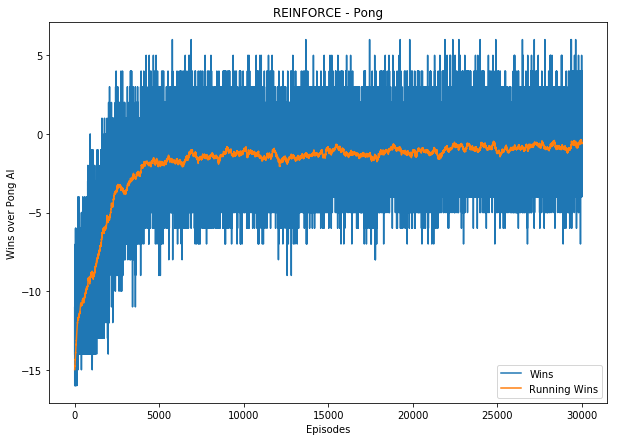

In [18]:
# data = pickle.load(open('./results/reinforce/pong_ep=30000history.p', 'rb'))
data = reinforce

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('REINFORCE - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()

## Does worse than REINFORCE-Karpathy

We will at a later time allow each episode to be played to the end, while limiting the gradient update to every batch size (to prevent GPU memory error).

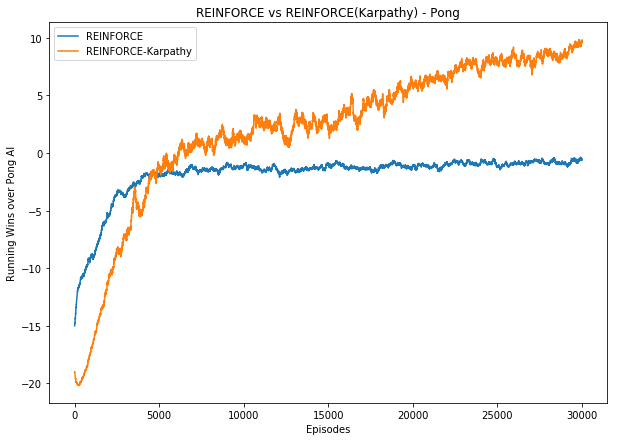

In [34]:
data1 = pickle.load(open('./results/reinforce/pong_ep=30000history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='REINFORCE')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()


## What is the NN Learning?

We display 20 of the affine1.weight matrix columns which is elementwise multiplied against an image vector.

It does a very poor job of learning the two things which Karpathy's numpy code has mastered.

1. The trajecory of the puck
2. Position of the 2 paddles

In [55]:
# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

    
model = Policy()
file_name='./results/reinforce/pong_ep=28000model.pt'
model.load_state_dict(torch.load(file_name))


(200, 1600)


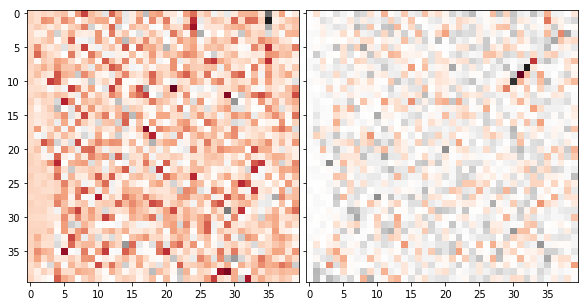

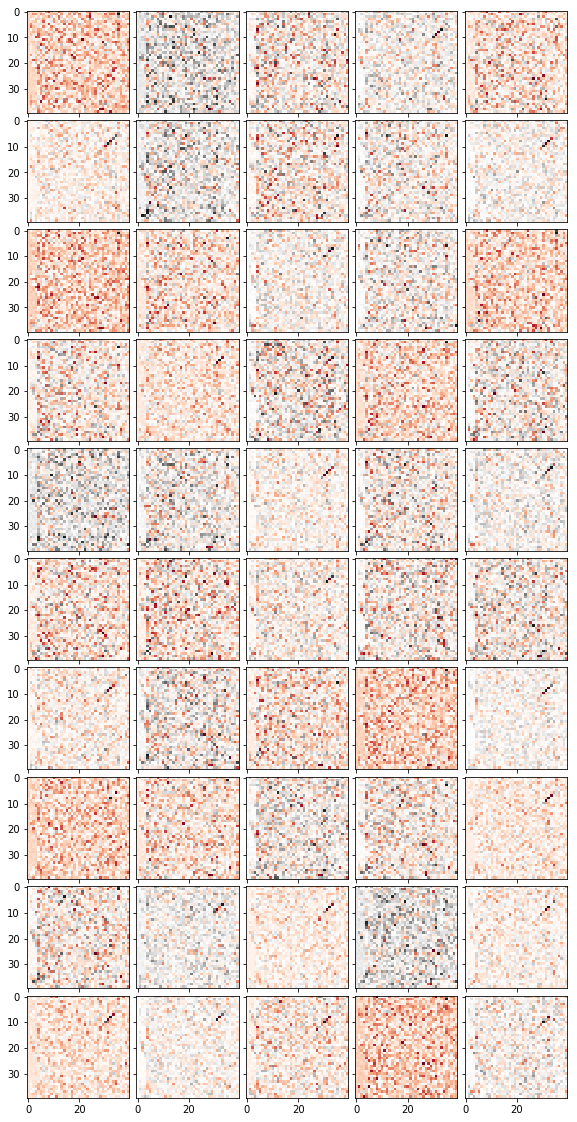

In [81]:
from mpl_toolkits.axes_grid1 import ImageGrid

W = {}

for name, param in model.named_parameters():
    W[name]=param.data.numpy()
    
print (W['affine1.weight'].shape)



# model = pickle.load(open('./results/pg-numpy/save (numpy-lr-1e-3-30000ep).p', 'rb'))

fig = plt.figure(1, (10., 5.))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)  # pad between axes in inch. 

# The AxesGrid object work as a list of axes.
image = W['affine1.weight'][0,:].reshape(40,40)
grid[0].imshow(image, cmap='RdGy')
image = W['affine1.weight'][9,:].reshape(40,40)
grid[1].imshow(image, cmap='RdGy')

plt.show()


fig = plt.figure(1, (12., 20.))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 5), axes_pad=0.1)  # pad between axes in inch. 

for i in range(50):
    # The AxesGrid object work as a list of axes.
    image = W['affine1.weight'][i,:].reshape(40,40)
    grid[i].imshow(image, cmap='RdGy')

plt.show()

## REINFORCE-V3

We tried a series of things to identify the performance discrepancies between Pytorch's implementation and REINFORCE-Karpathy:

(1) Downsampling - Not the problem  
(2) Batchsize - Not the problem  
(3) Update Rule - ADAM vs RMSProp - May not be the problem.

The underperformance is very likely due to the way the backprop is performed. An issue has been logged with PyTorch:

https://github.com/pytorch/pytorch/issues/5353

On the other hand, the weights does look different when we switch from ADAM to RMSProp. We will explore this in REINFORCE-V4.

In [3]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=10
batch_size = 1000  # Debug Underperformance - (2) change batch_sise
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.RMSprop(policy.parameters(), lr=1e-3)  # RMSProp instead of ADAM
# optimizer = optim.Adam(policy.parameters(), lr=1e-3)


# Debug Underperformance - (1) Change downsampling
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del rewards, policy_loss  # start deleting stuffs to address memory leak
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
prev_x = None
running_reward = -15

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000+1): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
        cur_x = prepro80(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        if done or t > batch_size:
            break
        

    # Calculate policy gradient and update Policy 
    finish_batch()
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # track memory usage every 100 episodes
    if i_episode % 2000 == 0:
         summary.print_(summary.summarize(muppy.get_objects()))
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)

Episode 0	Last Reward: -13.00	Running Reward: -14.98
                                         types |   # objects |   total size
============================================== | =========== | ============
                                   <class 'str |       74017 |     10.63 MB
                                  <class 'dict |       15045 |      6.22 MB
                                  <class 'type |        2895 |      2.94 MB
                                  <class 'code |       20499 |      2.83 MB
                                  <class 'list |        7535 |    935.34 KB
                                   <class 'set |        2085 |    887.59 KB
                                 <class 'tuple |       10841 |    721.97 KB
                     <class 'method_descriptor |        7740 |    544.22 KB
                               <class 'weakref |        5515 |    430.86 KB
  <class 'torch.autograd.function.FunctionMeta |         265 |    273.28 KB
            <class 'torch._thnn.uti

Episode 1270	Last Reward: -8.00	Running Reward: -9.70
Episode 1280	Last Reward: -13.00	Running Reward: -9.75
Episode 1290	Last Reward: -13.00	Running Reward: -9.76
Episode 1300	Last Reward: -13.00	Running Reward: -9.88
Episode 1310	Last Reward: -9.00	Running Reward: -10.00
Episode 1320	Last Reward: -8.00	Running Reward: -9.82
Episode 1330	Last Reward: -12.00	Running Reward: -9.75
Episode 1340	Last Reward: -8.00	Running Reward: -9.70
Episode 1350	Last Reward: -12.00	Running Reward: -9.68
Episode 1360	Last Reward: -6.00	Running Reward: -9.55
Episode 1370	Last Reward: -10.00	Running Reward: -9.46
Episode 1380	Last Reward: -2.00	Running Reward: -9.21
Episode 1390	Last Reward: -11.00	Running Reward: -9.04
Episode 1400	Last Reward: -10.00	Running Reward: -8.93
Episode 1410	Last Reward: -9.00	Running Reward: -8.86
Episode 1420	Last Reward: -11.00	Running Reward: -8.89
Episode 1430	Last Reward: -6.00	Running Reward: -8.81
Episode 1440	Last Reward: -8.00	Running Reward: -8.63
Episode 1450	Last 

Episode 2550	Last Reward: -7.00	Running Reward: -5.78
Episode 2560	Last Reward: -6.00	Running Reward: -5.78
Episode 2570	Last Reward: -3.00	Running Reward: -5.74
Episode 2580	Last Reward: -9.00	Running Reward: -5.70
Episode 2590	Last Reward: -2.00	Running Reward: -5.56
Episode 2600	Last Reward: -5.00	Running Reward: -5.50
Episode 2610	Last Reward: -5.00	Running Reward: -5.43
Episode 2620	Last Reward: -5.00	Running Reward: -5.47
Episode 2630	Last Reward: -2.00	Running Reward: -5.36
Episode 2640	Last Reward: -7.00	Running Reward: -5.29
Episode 2650	Last Reward: -4.00	Running Reward: -5.20
Episode 2660	Last Reward: -5.00	Running Reward: -5.13
Episode 2670	Last Reward: -3.00	Running Reward: -5.08
Episode 2680	Last Reward: -3.00	Running Reward: -5.17
Episode 2690	Last Reward: -9.00	Running Reward: -5.24
Episode 2700	Last Reward: -6.00	Running Reward: -5.23
Episode 2710	Last Reward: -2.00	Running Reward: -5.26
Episode 2720	Last Reward: -5.00	Running Reward: -5.34
Episode 2730	Last Reward: -3

Episode 4010	Last Reward: -6.00	Running Reward: -4.07
Episode 4020	Last Reward: -1.00	Running Reward: -4.05
Episode 4030	Last Reward: -5.00	Running Reward: -4.06
Episode 4040	Last Reward: -4.00	Running Reward: -3.98
Episode 4050	Last Reward: -6.00	Running Reward: -4.10
Episode 4060	Last Reward: -4.00	Running Reward: -4.15
Episode 4070	Last Reward: 0.00	Running Reward: -4.18
Episode 4080	Last Reward: -7.00	Running Reward: -4.14
Episode 4090	Last Reward: -5.00	Running Reward: -4.19
Episode 4100	Last Reward: -5.00	Running Reward: -4.04
Episode 4110	Last Reward: -4.00	Running Reward: -4.05
Episode 4120	Last Reward: -6.00	Running Reward: -4.11
Episode 4130	Last Reward: -5.00	Running Reward: -4.18
Episode 4140	Last Reward: -4.00	Running Reward: -4.11
Episode 4150	Last Reward: -1.00	Running Reward: -4.15
Episode 4160	Last Reward: -3.00	Running Reward: -4.06
Episode 4170	Last Reward: -4.00	Running Reward: -4.04
Episode 4180	Last Reward: -6.00	Running Reward: -3.97
Episode 4190	Last Reward: -5.

Episode 5540	Last Reward: -5.00	Running Reward: -2.56
Episode 5550	Last Reward: 1.00	Running Reward: -2.64
Episode 5560	Last Reward: -5.00	Running Reward: -2.66
Episode 5570	Last Reward: -3.00	Running Reward: -2.82
Episode 5580	Last Reward: -2.00	Running Reward: -2.70
Episode 5590	Last Reward: -2.00	Running Reward: -2.69
Episode 5600	Last Reward: -1.00	Running Reward: -2.62
Episode 5610	Last Reward: 0.00	Running Reward: -2.68
Episode 5620	Last Reward: -1.00	Running Reward: -2.77
Episode 5630	Last Reward: -1.00	Running Reward: -2.82
Episode 5640	Last Reward: -3.00	Running Reward: -2.93
Episode 5650	Last Reward: -2.00	Running Reward: -2.86
Episode 5660	Last Reward: -6.00	Running Reward: -2.88
Episode 5670	Last Reward: -5.00	Running Reward: -2.96
Episode 5680	Last Reward: -7.00	Running Reward: -2.87
Episode 5690	Last Reward: 0.00	Running Reward: -2.87
Episode 5700	Last Reward: 4.00	Running Reward: -2.81
Episode 5710	Last Reward: 0.00	Running Reward: -2.70
Episode 5720	Last Reward: -1.00	R

Episode 6830	Last Reward: -4.00	Running Reward: -2.41
Episode 6840	Last Reward: -3.00	Running Reward: -2.54
Episode 6850	Last Reward: 1.00	Running Reward: -2.53
Episode 6860	Last Reward: -4.00	Running Reward: -2.49
Episode 6870	Last Reward: 0.00	Running Reward: -2.39
Episode 6880	Last Reward: -3.00	Running Reward: -2.46
Episode 6890	Last Reward: 3.00	Running Reward: -2.43
Episode 6900	Last Reward: -5.00	Running Reward: -2.39
Episode 6910	Last Reward: -5.00	Running Reward: -2.38
Episode 6920	Last Reward: 0.00	Running Reward: -2.32
Episode 6930	Last Reward: 0.00	Running Reward: -2.34
Episode 6940	Last Reward: -5.00	Running Reward: -2.40
Episode 6950	Last Reward: -2.00	Running Reward: -2.42
Episode 6960	Last Reward: -4.00	Running Reward: -2.50
Episode 6970	Last Reward: -4.00	Running Reward: -2.54
Episode 6980	Last Reward: -2.00	Running Reward: -2.44
Episode 6990	Last Reward: -4.00	Running Reward: -2.40
Episode 7000	Last Reward: -2.00	Running Reward: -2.41
Episode 7010	Last Reward: 1.00	Ru

Episode 8120	Last Reward: -3.00	Running Reward: -2.74
Episode 8130	Last Reward: -4.00	Running Reward: -2.66
Episode 8140	Last Reward: -3.00	Running Reward: -2.63
Episode 8150	Last Reward: -1.00	Running Reward: -2.62
Episode 8160	Last Reward: -2.00	Running Reward: -2.60
Episode 8170	Last Reward: -3.00	Running Reward: -2.70
Episode 8180	Last Reward: -2.00	Running Reward: -2.62
Episode 8190	Last Reward: -5.00	Running Reward: -2.64
Episode 8200	Last Reward: -2.00	Running Reward: -2.64
Episode 8210	Last Reward: -3.00	Running Reward: -2.62
Episode 8220	Last Reward: -1.00	Running Reward: -2.63
Episode 8230	Last Reward: 2.00	Running Reward: -2.60
Episode 8240	Last Reward: -6.00	Running Reward: -2.44
Episode 8250	Last Reward: -3.00	Running Reward: -2.47
Episode 8260	Last Reward: -1.00	Running Reward: -2.46
Episode 8270	Last Reward: -3.00	Running Reward: -2.40
Episode 8280	Last Reward: -2.00	Running Reward: -2.29
Episode 8290	Last Reward: -2.00	Running Reward: -2.20
Episode 8300	Last Reward: -2.

Episode 9650	Last Reward: -1.00	Running Reward: -1.97
Episode 9660	Last Reward: -2.00	Running Reward: -2.03
Episode 9670	Last Reward: -4.00	Running Reward: -2.15
Episode 9680	Last Reward: 0.00	Running Reward: -2.15
Episode 9690	Last Reward: 2.00	Running Reward: -2.05
Episode 9700	Last Reward: -3.00	Running Reward: -2.12
Episode 9710	Last Reward: -1.00	Running Reward: -2.09
Episode 9720	Last Reward: -3.00	Running Reward: -2.13
Episode 9730	Last Reward: -2.00	Running Reward: -2.24
Episode 9740	Last Reward: -4.00	Running Reward: -2.28
Episode 9750	Last Reward: -1.00	Running Reward: -2.30
Episode 9760	Last Reward: -4.00	Running Reward: -2.22
Episode 9770	Last Reward: -1.00	Running Reward: -2.17
Episode 9780	Last Reward: -2.00	Running Reward: -2.01
Episode 9790	Last Reward: -4.00	Running Reward: -2.07
Episode 9800	Last Reward: -4.00	Running Reward: -2.03
Episode 9810	Last Reward: -5.00	Running Reward: -2.12
Episode 9820	Last Reward: -2.00	Running Reward: -2.03
Episode 9830	Last Reward: -4.0

Episode 10920	Last Reward: -4.00	Running Reward: -2.11
Episode 10930	Last Reward: -2.00	Running Reward: -2.01
Episode 10940	Last Reward: -2.00	Running Reward: -2.03
Episode 10950	Last Reward: -2.00	Running Reward: -2.03
Episode 10960	Last Reward: -3.00	Running Reward: -2.10
Episode 10970	Last Reward: 0.00	Running Reward: -1.94
Episode 10980	Last Reward: -2.00	Running Reward: -1.93
Episode 10990	Last Reward: -6.00	Running Reward: -1.95
Episode 11000	Last Reward: -2.00	Running Reward: -2.14
Episode 11010	Last Reward: -2.00	Running Reward: -2.18
Episode 11020	Last Reward: -2.00	Running Reward: -2.15
Episode 11030	Last Reward: 1.00	Running Reward: -2.16
Episode 11040	Last Reward: -4.00	Running Reward: -2.25
Episode 11050	Last Reward: -3.00	Running Reward: -2.32
Episode 11060	Last Reward: -3.00	Running Reward: -2.28
Episode 11070	Last Reward: -2.00	Running Reward: -2.34
Episode 11080	Last Reward: 1.00	Running Reward: -2.19
Episode 11090	Last Reward: -2.00	Running Reward: -2.15
Episode 11100

Episode 12180	Last Reward: -5.00	Running Reward: -1.81
Episode 12190	Last Reward: -5.00	Running Reward: -1.79
Episode 12200	Last Reward: -1.00	Running Reward: -1.79
Episode 12210	Last Reward: 1.00	Running Reward: -1.79
Episode 12220	Last Reward: 1.00	Running Reward: -1.83
Episode 12230	Last Reward: 2.00	Running Reward: -1.84
Episode 12240	Last Reward: -3.00	Running Reward: -1.86
Episode 12250	Last Reward: -1.00	Running Reward: -1.84
Episode 12260	Last Reward: 2.00	Running Reward: -1.93
Episode 12270	Last Reward: -4.00	Running Reward: -1.97
Episode 12280	Last Reward: 0.00	Running Reward: -1.87
Episode 12290	Last Reward: -2.00	Running Reward: -1.82
Episode 12300	Last Reward: -3.00	Running Reward: -1.86
Episode 12310	Last Reward: -4.00	Running Reward: -1.85
Episode 12320	Last Reward: -4.00	Running Reward: -1.96
Episode 12330	Last Reward: -4.00	Running Reward: -1.90
Episode 12340	Last Reward: -5.00	Running Reward: -1.82
Episode 12350	Last Reward: -3.00	Running Reward: -1.88
Episode 12360	L

Episode 13680	Last Reward: -1.00	Running Reward: -1.60
Episode 13690	Last Reward: 1.00	Running Reward: -1.67
Episode 13700	Last Reward: -2.00	Running Reward: -1.54
Episode 13710	Last Reward: 1.00	Running Reward: -1.48
Episode 13720	Last Reward: -1.00	Running Reward: -1.44
Episode 13730	Last Reward: -3.00	Running Reward: -1.49
Episode 13740	Last Reward: -2.00	Running Reward: -1.54
Episode 13750	Last Reward: -4.00	Running Reward: -1.46
Episode 13760	Last Reward: -7.00	Running Reward: -1.49
Episode 13770	Last Reward: -5.00	Running Reward: -1.52
Episode 13780	Last Reward: 2.00	Running Reward: -1.35
Episode 13790	Last Reward: 0.00	Running Reward: -1.25
Episode 13800	Last Reward: -1.00	Running Reward: -1.19
Episode 13810	Last Reward: -1.00	Running Reward: -1.24
Episode 13820	Last Reward: -4.00	Running Reward: -1.39
Episode 13830	Last Reward: -5.00	Running Reward: -1.49
Episode 13840	Last Reward: 2.00	Running Reward: -1.50
Episode 13850	Last Reward: -5.00	Running Reward: -1.50
Episode 13860	L

Episode 14950	Last Reward: -3.00	Running Reward: -0.98
Episode 14960	Last Reward: 4.00	Running Reward: -0.98
Episode 14970	Last Reward: 0.00	Running Reward: -1.03
Episode 14980	Last Reward: -1.00	Running Reward: -0.93
Episode 14990	Last Reward: -3.00	Running Reward: -0.93
Episode 15000	Last Reward: 0.00	Running Reward: -0.94
Episode 15010	Last Reward: -1.00	Running Reward: -0.98
Episode 15020	Last Reward: -1.00	Running Reward: -1.01
Episode 15030	Last Reward: 4.00	Running Reward: -0.94
Episode 15040	Last Reward: 1.00	Running Reward: -1.01
Episode 15050	Last Reward: 3.00	Running Reward: -1.08
Episode 15060	Last Reward: -2.00	Running Reward: -1.06
Episode 15070	Last Reward: 5.00	Running Reward: -1.04
Episode 15080	Last Reward: -6.00	Running Reward: -1.03
Episode 15090	Last Reward: 4.00	Running Reward: -0.95
Episode 15100	Last Reward: -2.00	Running Reward: -0.92
Episode 15110	Last Reward: -2.00	Running Reward: -0.87
Episode 15120	Last Reward: -3.00	Running Reward: -1.04
Episode 15130	Last

Episode 16220	Last Reward: -2.00	Running Reward: -1.22
Episode 16230	Last Reward: 1.00	Running Reward: -1.29
Episode 16240	Last Reward: -1.00	Running Reward: -1.26
Episode 16250	Last Reward: -1.00	Running Reward: -1.24
Episode 16260	Last Reward: 0.00	Running Reward: -1.26
Episode 16270	Last Reward: -5.00	Running Reward: -1.06
Episode 16280	Last Reward: -1.00	Running Reward: -1.01
Episode 16290	Last Reward: 2.00	Running Reward: -1.02
Episode 16300	Last Reward: 0.00	Running Reward: -0.90
Episode 16310	Last Reward: -2.00	Running Reward: -0.95
Episode 16320	Last Reward: 4.00	Running Reward: -0.82
Episode 16330	Last Reward: 3.00	Running Reward: -0.78
Episode 16340	Last Reward: -1.00	Running Reward: -0.75
Episode 16350	Last Reward: 2.00	Running Reward: -0.77
Episode 16360	Last Reward: -5.00	Running Reward: -0.89
Episode 16370	Last Reward: -2.00	Running Reward: -0.90
Episode 16380	Last Reward: -1.00	Running Reward: -0.92
Episode 16390	Last Reward: -3.00	Running Reward: -0.94
Episode 16400	Las

Episode 17720	Last Reward: -4.00	Running Reward: -1.19
Episode 17730	Last Reward: -2.00	Running Reward: -1.25
Episode 17740	Last Reward: -3.00	Running Reward: -1.33
Episode 17750	Last Reward: -3.00	Running Reward: -1.23
Episode 17760	Last Reward: 1.00	Running Reward: -1.17
Episode 17770	Last Reward: 3.00	Running Reward: -1.26
Episode 17780	Last Reward: -4.00	Running Reward: -1.18
Episode 17790	Last Reward: 3.00	Running Reward: -0.88
Episode 17800	Last Reward: -4.00	Running Reward: -0.91
Episode 17810	Last Reward: 0.00	Running Reward: -0.88
Episode 17820	Last Reward: -3.00	Running Reward: -0.95
Episode 17830	Last Reward: -6.00	Running Reward: -1.15
Episode 17840	Last Reward: -4.00	Running Reward: -1.19
Episode 17850	Last Reward: 1.00	Running Reward: -1.11
Episode 17860	Last Reward: -5.00	Running Reward: -1.08
Episode 17870	Last Reward: -1.00	Running Reward: -1.15
Episode 17880	Last Reward: -5.00	Running Reward: -1.12
Episode 17890	Last Reward: -3.00	Running Reward: -1.13
Episode 17900	L

Episode 18990	Last Reward: -4.00	Running Reward: -1.11
Episode 19000	Last Reward: -5.00	Running Reward: -1.08
Episode 19010	Last Reward: -4.00	Running Reward: -1.10
Episode 19020	Last Reward: -2.00	Running Reward: -1.19
Episode 19030	Last Reward: -1.00	Running Reward: -1.16
Episode 19040	Last Reward: -5.00	Running Reward: -1.26
Episode 19050	Last Reward: -4.00	Running Reward: -1.34
Episode 19060	Last Reward: 2.00	Running Reward: -1.20
Episode 19070	Last Reward: 5.00	Running Reward: -1.16
Episode 19080	Last Reward: 0.00	Running Reward: -1.09
Episode 19090	Last Reward: -1.00	Running Reward: -1.08
Episode 19100	Last Reward: -1.00	Running Reward: -0.94
Episode 19110	Last Reward: 1.00	Running Reward: -0.89
Episode 19120	Last Reward: -2.00	Running Reward: -0.91
Episode 19130	Last Reward: 1.00	Running Reward: -0.88
Episode 19140	Last Reward: -1.00	Running Reward: -0.97
Episode 19150	Last Reward: 2.00	Running Reward: -0.86
Episode 19160	Last Reward: -2.00	Running Reward: -0.70
Episode 19170	La

Episode 20260	Last Reward: 0.00	Running Reward: -1.03
Episode 20270	Last Reward: 0.00	Running Reward: -0.97
Episode 20280	Last Reward: 0.00	Running Reward: -0.81
Episode 20290	Last Reward: 2.00	Running Reward: -0.71
Episode 20300	Last Reward: 4.00	Running Reward: -0.77
Episode 20310	Last Reward: 3.00	Running Reward: -0.92
Episode 20320	Last Reward: -4.00	Running Reward: -1.01
Episode 20330	Last Reward: -1.00	Running Reward: -0.89
Episode 20340	Last Reward: -1.00	Running Reward: -1.06
Episode 20350	Last Reward: -1.00	Running Reward: -1.08
Episode 20360	Last Reward: -2.00	Running Reward: -1.09
Episode 20370	Last Reward: -1.00	Running Reward: -1.16
Episode 20380	Last Reward: 1.00	Running Reward: -1.17
Episode 20390	Last Reward: -5.00	Running Reward: -1.13
Episode 20400	Last Reward: -2.00	Running Reward: -0.95
Episode 20410	Last Reward: 0.00	Running Reward: -0.95
Episode 20420	Last Reward: 2.00	Running Reward: -1.05
Episode 20430	Last Reward: -1.00	Running Reward: -0.99
Episode 20440	Last 

Episode 21770	Last Reward: 0.00	Running Reward: -0.50
Episode 21780	Last Reward: -3.00	Running Reward: -0.54
Episode 21790	Last Reward: -2.00	Running Reward: -0.60
Episode 21800	Last Reward: 0.00	Running Reward: -0.47
Episode 21810	Last Reward: -1.00	Running Reward: -0.52
Episode 21820	Last Reward: 1.00	Running Reward: -0.58
Episode 21830	Last Reward: -2.00	Running Reward: -0.59
Episode 21840	Last Reward: -1.00	Running Reward: -0.58
Episode 21850	Last Reward: -3.00	Running Reward: -0.65
Episode 21860	Last Reward: 4.00	Running Reward: -0.60
Episode 21870	Last Reward: -3.00	Running Reward: -0.65
Episode 21880	Last Reward: 4.00	Running Reward: -0.65
Episode 21890	Last Reward: -2.00	Running Reward: -0.75
Episode 21900	Last Reward: 5.00	Running Reward: -0.67
Episode 21910	Last Reward: -1.00	Running Reward: -0.79
Episode 21920	Last Reward: 2.00	Running Reward: -0.73
Episode 21930	Last Reward: -1.00	Running Reward: -0.75
Episode 21940	Last Reward: 3.00	Running Reward: -0.69
Episode 21950	Last

Episode 23040	Last Reward: -3.00	Running Reward: -0.46
Episode 23050	Last Reward: 1.00	Running Reward: -0.49
Episode 23060	Last Reward: -4.00	Running Reward: -0.60
Episode 23070	Last Reward: -4.00	Running Reward: -0.62
Episode 23080	Last Reward: -1.00	Running Reward: -0.59
Episode 23090	Last Reward: -5.00	Running Reward: -0.58
Episode 23100	Last Reward: -3.00	Running Reward: -0.56
Episode 23110	Last Reward: 6.00	Running Reward: -0.56
Episode 23120	Last Reward: 0.00	Running Reward: -0.62
Episode 23130	Last Reward: 3.00	Running Reward: -0.64
Episode 23140	Last Reward: -1.00	Running Reward: -0.60
Episode 23150	Last Reward: 2.00	Running Reward: -0.56
Episode 23160	Last Reward: 0.00	Running Reward: -0.54
Episode 23170	Last Reward: -2.00	Running Reward: -0.57
Episode 23180	Last Reward: 0.00	Running Reward: -0.55
Episode 23190	Last Reward: 1.00	Running Reward: -0.60
Episode 23200	Last Reward: 2.00	Running Reward: -0.45
Episode 23210	Last Reward: 4.00	Running Reward: -0.50
Episode 23220	Last R

Episode 24310	Last Reward: 0.00	Running Reward: -0.59
Episode 24320	Last Reward: 1.00	Running Reward: -0.64
Episode 24330	Last Reward: -2.00	Running Reward: -0.83
Episode 24340	Last Reward: -3.00	Running Reward: -0.85
Episode 24350	Last Reward: -3.00	Running Reward: -0.94
Episode 24360	Last Reward: 0.00	Running Reward: -1.05
Episode 24370	Last Reward: -1.00	Running Reward: -1.08
Episode 24380	Last Reward: -4.00	Running Reward: -1.07
Episode 24390	Last Reward: 1.00	Running Reward: -0.99
Episode 24400	Last Reward: -5.00	Running Reward: -1.02
Episode 24410	Last Reward: -2.00	Running Reward: -0.97
Episode 24420	Last Reward: -1.00	Running Reward: -0.96
Episode 24430	Last Reward: -7.00	Running Reward: -1.03
Episode 24440	Last Reward: 2.00	Running Reward: -1.05
Episode 24450	Last Reward: -4.00	Running Reward: -1.09
Episode 24460	Last Reward: 2.00	Running Reward: -1.03
Episode 24470	Last Reward: -3.00	Running Reward: -1.00
Episode 24480	Last Reward: -1.00	Running Reward: -1.04
Episode 24490	La

Episode 25820	Last Reward: 1.00	Running Reward: -0.62
Episode 25830	Last Reward: -1.00	Running Reward: -0.47
Episode 25840	Last Reward: 0.00	Running Reward: -0.32
Episode 25850	Last Reward: -1.00	Running Reward: -0.29
Episode 25860	Last Reward: 5.00	Running Reward: -0.17
Episode 25870	Last Reward: -2.00	Running Reward: -0.13
Episode 25880	Last Reward: 1.00	Running Reward: -0.15
Episode 25890	Last Reward: 1.00	Running Reward: -0.13
Episode 25900	Last Reward: -3.00	Running Reward: -0.24
Episode 25910	Last Reward: 0.00	Running Reward: -0.26
Episode 25920	Last Reward: 1.00	Running Reward: -0.39
Episode 25930	Last Reward: -2.00	Running Reward: -0.52
Episode 25940	Last Reward: -3.00	Running Reward: -0.52
Episode 25950	Last Reward: 0.00	Running Reward: -0.39
Episode 25960	Last Reward: 3.00	Running Reward: -0.27
Episode 25970	Last Reward: -4.00	Running Reward: -0.38
Episode 25980	Last Reward: 3.00	Running Reward: -0.30
Episode 25990	Last Reward: -2.00	Running Reward: -0.44
Episode 26000	Last R

Episode 27090	Last Reward: -3.00	Running Reward: -0.84
Episode 27100	Last Reward: -1.00	Running Reward: -0.85
Episode 27110	Last Reward: -4.00	Running Reward: -1.02
Episode 27120	Last Reward: -3.00	Running Reward: -0.99
Episode 27130	Last Reward: 6.00	Running Reward: -0.99
Episode 27140	Last Reward: -4.00	Running Reward: -1.06
Episode 27150	Last Reward: 6.00	Running Reward: -1.00
Episode 27160	Last Reward: 0.00	Running Reward: -1.13
Episode 27170	Last Reward: 3.00	Running Reward: -0.97
Episode 27180	Last Reward: 2.00	Running Reward: -1.01
Episode 27190	Last Reward: -2.00	Running Reward: -1.11
Episode 27200	Last Reward: 2.00	Running Reward: -0.99
Episode 27210	Last Reward: -1.00	Running Reward: -0.89
Episode 27220	Last Reward: 0.00	Running Reward: -1.01
Episode 27230	Last Reward: 1.00	Running Reward: -0.89
Episode 27240	Last Reward: -1.00	Running Reward: -0.95
Episode 27250	Last Reward: -5.00	Running Reward: -0.99
Episode 27260	Last Reward: -4.00	Running Reward: -1.03
Episode 27270	Last

Episode 28360	Last Reward: -3.00	Running Reward: -0.77
Episode 28370	Last Reward: 1.00	Running Reward: -0.68
Episode 28380	Last Reward: -1.00	Running Reward: -0.64
Episode 28390	Last Reward: 4.00	Running Reward: -0.64
Episode 28400	Last Reward: -4.00	Running Reward: -0.62
Episode 28410	Last Reward: 0.00	Running Reward: -0.53
Episode 28420	Last Reward: 0.00	Running Reward: -0.62
Episode 28430	Last Reward: 4.00	Running Reward: -0.50
Episode 28440	Last Reward: -4.00	Running Reward: -0.56
Episode 28450	Last Reward: 2.00	Running Reward: -0.61
Episode 28460	Last Reward: -4.00	Running Reward: -0.67
Episode 28470	Last Reward: -1.00	Running Reward: -0.66
Episode 28480	Last Reward: -3.00	Running Reward: -0.68
Episode 28490	Last Reward: 0.00	Running Reward: -0.66
Episode 28500	Last Reward: -1.00	Running Reward: -0.73
Episode 28510	Last Reward: -5.00	Running Reward: -0.87
Episode 28520	Last Reward: -4.00	Running Reward: -0.87
Episode 28530	Last Reward: -3.00	Running Reward: -0.90
Episode 28540	Las

Episode 29870	Last Reward: 0.00	Running Reward: -0.64
Episode 29880	Last Reward: -1.00	Running Reward: -0.59
Episode 29890	Last Reward: 3.00	Running Reward: -0.56
Episode 29900	Last Reward: -1.00	Running Reward: -0.56
Episode 29910	Last Reward: -5.00	Running Reward: -0.58
Episode 29920	Last Reward: -5.00	Running Reward: -0.51
Episode 29930	Last Reward: -1.00	Running Reward: -0.43
Episode 29940	Last Reward: 2.00	Running Reward: -0.30
Episode 29950	Last Reward: 4.00	Running Reward: -0.27
Episode 29960	Last Reward: -3.00	Running Reward: -0.33
Episode 29970	Last Reward: -3.00	Running Reward: -0.39
Episode 29980	Last Reward: -1.00	Running Reward: -0.46
Episode 29990	Last Reward: 0.00	Running Reward: -0.32
Episode 30000	Last Reward: -4.00	Running Reward: -0.49
                                         types |   # objects |   total size
============================================== | =========== | ============
                                   <class 'str |       74018 |     10.63 MB
       

In [4]:
file_name = './results/reinforce/pong_'+'ep='+str(i_episode+1)+'history.p'
pickle.dump(reinforce, open(file_name, 'wb'))

### REINFORCE-V3
Regardless of the downsampling scheme, Pytorch's recommended way to implement REINFORCE underperforms REINFORCE-Karpathy. Plateau starts at Running Reward = -1.0



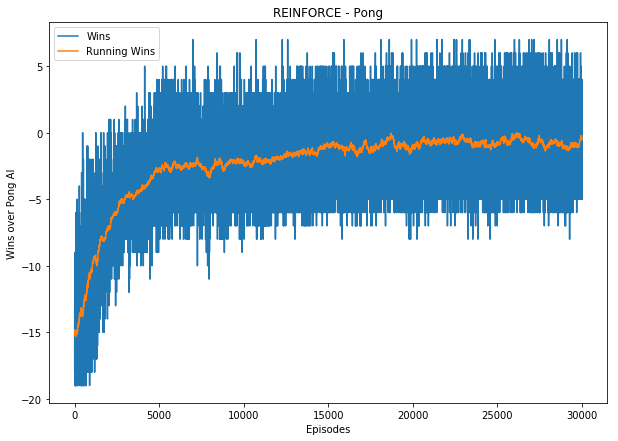

In [5]:
# data = pickle.load(open('./results/reinforce/pong_ep=30000history.p', 'rb'))
data = reinforce

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('REINFORCE - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()

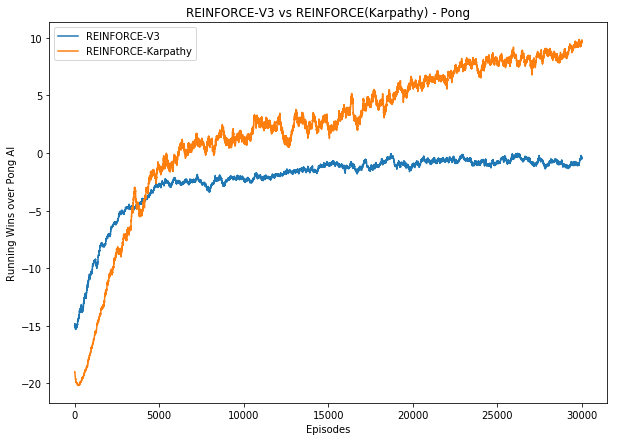

In [7]:
data1 = pickle.load(open('./results/reinforce/pong_ep=30001history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='REINFORCE-V3')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE-V3 vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()

## REINFORCE-V4

We tried a series of things to identify the performance discrepancies between Pytorch's implementation and REINFORCE-Karpathy:

(1) Downsampling - Not the problem  
(2) Batchsize - Not the problem  
(3) Update Rule - ADAM vs RMSProp - ???

We will explore how the learning differs in RL between the update rules (SGD w/ Momentum, RmsProp and ADAM)

In [17]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=100
batch_size = 1000  # Debug Underperformance - (2) change batch_size
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


# Debug Underperformance - (1) Change downsampling
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch(optimizer):
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del rewards, policy_loss  # start deleting stuffs to address memory leak
    del policy.rewards[:]
    del policy.saved_log_probs[:]

# Main loop
# Try out different optimizers
names =['RmsProp-lr=1e-3', 'SGD-lr=1e-3', 'RmsProp-lr=1e-4', 'SGD-lr=1e-4'] 

for i in range(len(names)):
    
    start = time.time()
    
    reinforce=[]  # To store training history
    
    # Call an instance of the policy and set optimizer
    policy = Policy().cuda()
    
    if i is 0:
        optimizer = optim.RMSprop(policy.parameters(), lr=1e-3, weight_decay=0.01)
    elif i is 1:
        optimizer = optim.SGD(policy.parameters(), lr=1e-3, momentum=0.9)
    elif i is 2:
        optimizer = optim.RMSprop(policy.parameters(), lr=1e-4, weight_decay=0.01)
    else:
        optimizer = optim.SGD(policy.parameters(), lr=1e-4, momentum=0.9)
        
    print ("Optimizer is {}!".format(names[i]))

    # Main loop
    prev_x = None
    running_reward = -15

    start = time.time()
    # for i_episode in count(1):  # Infinite loop
    for i_episode in range(15000+1): # just run 15000 episode    
        state = env.reset()
        reward_sum = 0
    
        for t in range(10000):  # Don't infinite loop while learning
        
            # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
            cur_x = prepro80(state)
            state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
            prev_x = cur_x
        
            # Sample an action from Policy based on state provided by env
            action = select_action(state)
        
            # step env through the sampled action
            state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
            reward_sum += reward
        
            if render:
                env.render()
            
            # append reward to policy.reward[]
            # this is needed to calculate policy gradient at the end of the episode  
            policy.rewards.append(reward)
        
            if done or t > batch_size:
                break
        
        
        # Calculate policy gradient and update Policy 
        finish_batch(optimizer)
        gc.collect()  # clean up some garbage
        torch.cuda.empty_cache()  # Release GPU memory
    
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
        reinforce.append([reward_sum, running_reward])
        # print out and show sign of life
        if i_episode % log_interval == 0:
            print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                    i_episode, reward_sum, running_reward))
    
        # track memory usage every 100 episodes
        if i_episode % 2000 == 0:
             # summary.print_(summary.summarize(muppy.get_objects()))
             file_name = './results/reinforce/pong_'+names[i]+'ep='+str(i_episode)+'model.pt'
             torch.save(policy.state_dict(), file_name)

    end = time.time()
    print ("Time taken:", start-end)
    
    history_file = './results/reinforce/pong_'+names[i]+'ep='+str(i_episode+1)+'history.p'
    pickle.dump(reinforce, open(history_file, 'wb'))

Optimizer is RmsProp-lr=1e-3!
Episode 0	Last Reward: -13.00	Running Reward: -14.98
Episode 100	Last Reward: -11.00	Running Reward: -14.82
Episode 200	Last Reward: -15.00	Running Reward: -13.93
Episode 300	Last Reward: -11.00	Running Reward: -12.90
Episode 400	Last Reward: -17.00	Running Reward: -12.27
Episode 500	Last Reward: -12.00	Running Reward: -11.30
Episode 600	Last Reward: -8.00	Running Reward: -10.36
Episode 700	Last Reward: -10.00	Running Reward: -9.61
Episode 800	Last Reward: -7.00	Running Reward: -8.57
Episode 900	Last Reward: -9.00	Running Reward: -7.77
Episode 1000	Last Reward: -8.00	Running Reward: -7.10
Episode 1100	Last Reward: -8.00	Running Reward: -6.93
Episode 1200	Last Reward: -4.00	Running Reward: -6.73
Episode 1300	Last Reward: -3.00	Running Reward: -6.19
Episode 1400	Last Reward: -10.00	Running Reward: -5.72
Episode 1500	Last Reward: -3.00	Running Reward: -5.74
Episode 1600	Last Reward: -4.00	Running Reward: -5.12
Episode 1700	Last Reward: -4.00	Running Reward: -

Episode 0	Last Reward: -17.00	Running Reward: -15.02
Episode 100	Last Reward: -14.00	Running Reward: -15.66
Episode 200	Last Reward: -17.00	Running Reward: -16.46
Episode 300	Last Reward: -18.00	Running Reward: -16.26
Episode 400	Last Reward: -19.00	Running Reward: -15.80
Episode 500	Last Reward: -19.00	Running Reward: -14.73
Episode 600	Last Reward: -17.00	Running Reward: -15.14
Episode 700	Last Reward: -18.00	Running Reward: -15.59
Episode 800	Last Reward: -11.00	Running Reward: -13.63
Episode 900	Last Reward: -13.00	Running Reward: -14.22
Episode 1000	Last Reward: -18.00	Running Reward: -14.19
Episode 1100	Last Reward: -8.00	Running Reward: -14.09
Episode 1200	Last Reward: -11.00	Running Reward: -14.05
Episode 1300	Last Reward: -13.00	Running Reward: -13.99
Episode 1400	Last Reward: -13.00	Running Reward: -13.95
Episode 1500	Last Reward: -6.00	Running Reward: -13.59
Episode 1600	Last Reward: -19.00	Running Reward: -13.62
Episode 1700	Last Reward: -15.00	Running Reward: -13.61
Episod

Episode 14700	Last Reward: -12.00	Running Reward: -12.08
Episode 14800	Last Reward: -16.00	Running Reward: -12.55
Episode 14900	Last Reward: -15.00	Running Reward: -13.03
Episode 15000	Last Reward: -8.00	Running Reward: -12.04
Time taken: -16795.61459994316
Optimizer is RmsProp-lr=1e-4!
Episode 0	Last Reward: -12.00	Running Reward: -14.97
Episode 100	Last Reward: -15.00	Running Reward: -15.04
Episode 200	Last Reward: -15.00	Running Reward: -14.36
Episode 300	Last Reward: -11.00	Running Reward: -14.48
Episode 400	Last Reward: -12.00	Running Reward: -14.41
Episode 500	Last Reward: -13.00	Running Reward: -14.38
Episode 600	Last Reward: -13.00	Running Reward: -14.15
Episode 700	Last Reward: -12.00	Running Reward: -14.02
Episode 800	Last Reward: -18.00	Running Reward: -14.15
Episode 900	Last Reward: -13.00	Running Reward: -13.56
Episode 1000	Last Reward: -17.00	Running Reward: -13.39
Episode 1100	Last Reward: -7.00	Running Reward: -13.12
Episode 1200	Last Reward: -15.00	Running Reward: -13.

Episode 14500	Last Reward: 0.00	Running Reward: -1.26
Episode 14600	Last Reward: 0.00	Running Reward: -1.13
Episode 14700	Last Reward: -1.00	Running Reward: -1.22
Episode 14800	Last Reward: 0.00	Running Reward: -1.46
Episode 14900	Last Reward: -2.00	Running Reward: -1.49
Episode 15000	Last Reward: -3.00	Running Reward: -1.21
Time taken: -16834.2718770504
Optimizer is SGD-lr=1e-4!
Episode 0	Last Reward: -20.00	Running Reward: -15.05
Episode 100	Last Reward: -9.00	Running Reward: -14.60
Episode 200	Last Reward: -18.00	Running Reward: -14.41
Episode 300	Last Reward: -11.00	Running Reward: -14.52
Episode 400	Last Reward: -10.00	Running Reward: -14.57
Episode 500	Last Reward: -15.00	Running Reward: -14.30
Episode 600	Last Reward: -15.00	Running Reward: -13.88
Episode 700	Last Reward: -15.00	Running Reward: -13.42
Episode 800	Last Reward: -16.00	Running Reward: -13.58
Episode 900	Last Reward: -17.00	Running Reward: -13.72
Episode 1000	Last Reward: -13.00	Running Reward: -13.37
Episode 1100	L

Episode 14400	Last Reward: -5.00	Running Reward: -1.98
Episode 14500	Last Reward: 3.00	Running Reward: -1.86
Episode 14600	Last Reward: -3.00	Running Reward: -1.89
Episode 14700	Last Reward: 2.00	Running Reward: -1.41
Episode 14800	Last Reward: -1.00	Running Reward: -1.42
Episode 14900	Last Reward: -2.00	Running Reward: -1.58
Episode 15000	Last Reward: -4.00	Running Reward: -1.66
Time taken: -16861.506997823715


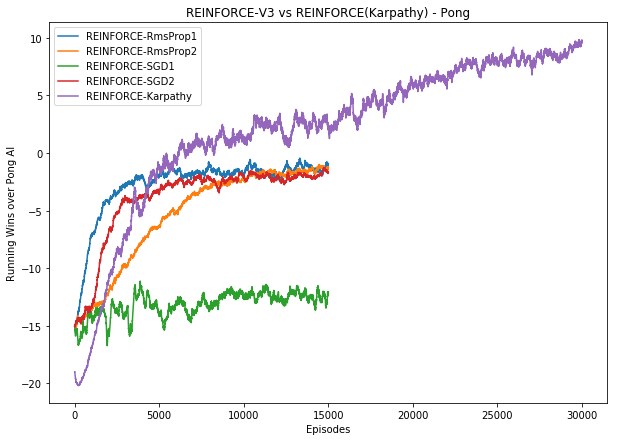

In [51]:

data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))
data1 = pickle.load(open('./results/reinforce/pong_RmsProp-lr=1e-3ep=15001history.p', 'rb'))
data3 = pickle.load(open('./results/reinforce/pong_RmsProp-lr=1e-4ep=15001history.p', 'rb'))
data4 = pickle.load(open('./results/reinforce/pong_SGD-lr=1e-3ep=15001history.p', 'rb'))
data5 = pickle.load(open('./results/reinforce/pong_SGD-lr=1e-4ep=15001history.p', 'rb'))


# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(15001)), np.array(data1)[:,1], label='REINFORCE-RmsProp1')
plt.plot(list(range(15001)), np.array(data3)[30002:,1], label='REINFORCE-RmsProp2')
plt.plot(list(range(15001)), np.array(data4)[15001:,1], label='REINFORCE-SGD1')
plt.plot(list(range(15001)), np.array(data5)[45003:,1], label='REINFORCE-SGD2')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE-V3 vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()

## REINFORCE-V5

Identified a bug in how discounted reward is calculated. But correcting it does not seem to break the Running Reward = 0.0 barrier.


In [ ]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
render=False
load = False   # Load a pre-trained model
log_interval=10
batch_size = 800  # Debug Underperformance - (2) change batch_size
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return action_scores   # output logit


# Debug Underperformance - (1) Change downsampling
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    
    # Use Policy to generate probability for action
    logit = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Replace PyTorch recommended RL implementation
    # Sample action stochastically    
    # m = Categorical(probs)
    # action = m.sample()

    prob = F.softmax(logit, dim=1)
    log_prob = F.log_softmax(logit, dim=1)
    action = prob.multinomial().data   # action is sampled here
    
    if verbose:
        print ("Pong's state output:", state.shape)
        print ("NN output:", logit)
        print ("Pong Action:", action)
        print ("log_prob(action):", log_prob)
        
    log_prob = log_prob.gather(1, Variable(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(log_prob)
    
    if verbose:
        print ("Stacked log_prob:", policy.saved_log_probs)
    
    return action


def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:    
        print ("Rewards:", policy.rewards)
            
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        if r != 0:  # reset the sum, since this was a game boundary (pong specific!)
            R = 0
        R = r + gamma * R
        rewards.insert(0, R)
        
    if verbose:    
        print ("Discounted Rewards:", rewards)
       
    rewards = torch.Tensor(rewards)
    
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]


    # Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.RMSprop(policy.parameters(), lr=5e-5, weight_decay=0.01)  # RMSProp instead of ADAM

if load is True:
    file_name='./results/reinforce/pong_ep=20000model.pt'
    policy.load_state_dict(torch.load(file_name))

# Main loop
prev_x = None
running_reward = -15

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000+1): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
        cur_x = prepro80(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        action = action.cpu().numpy()+2
        
        if verbose:
            print ("Converted action: ", action)
            
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        if done or t > batch_size:
            break
        

    # Calculate policy gradient and update Policy 
    finish_batch()
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # track memory usage every 100 episodes
    if i_episode % 2000 == 0:
         # summary.print_(summary.summarize(muppy.get_objects()))
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)
env.close()

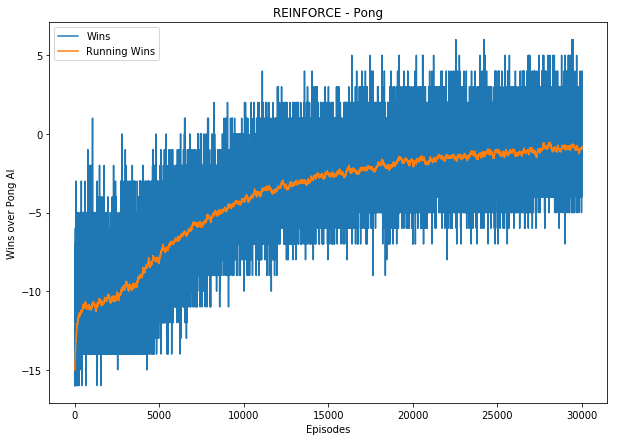

In [3]:
data = reinforce

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('REINFORCE - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()

In [4]:
name = 'RmsProp-lr5e-5'
history_file = './results/reinforce/pong_'+name+'ep='+str(i_episode+1)+'history.p'
pickle.dump(reinforce, open(history_file, 'wb'))

## Definite Underperformance

Pytorch's recommended approach to RL severely underperforms compared to Karpathy's direct backprop approach. The agents are stuck in local optima and incapable of exploring better strategies.

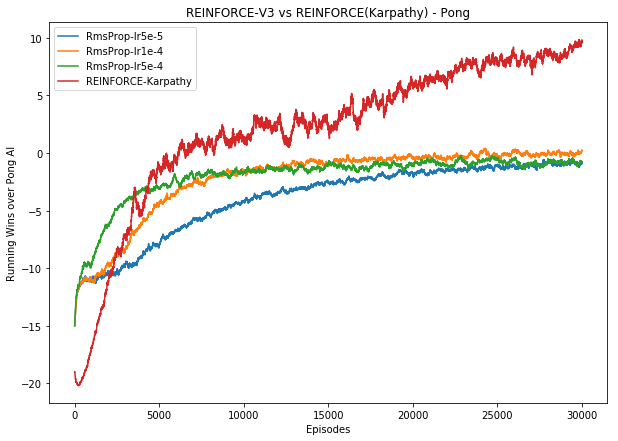

In [5]:
data1 = pickle.load(open('./results/reinforce/rmsprop-lr5e-5/pong_RmsProp-lr5e-5ep=30001history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))
data3 = pickle.load(open('./results/reinforce/rmsprop-lr1e-4/pong_RmsProp-lr1e-4ep=30001history.p', 'rb'))
data4 = pickle.load(open('./results/reinforce/rmsprop-lr5e-4/pong_RmsProp-lr5e-4ep=30001history.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='RmsProp-lr5e-5')
plt.plot(list(range(1,len(data3)+1)), np.array(data3)[:,1], label='RmsProp-lr1e-4')
plt.plot(list(range(1,len(data4)+1)), np.array(data4)[:,1], label='RmsProp-lr5e-4')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE-V3 vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()

## REINFORCE-V6

We know the agent is not exploring enough based on Chris' temperature experiment. I want to explore if we can reduce model complexity (200 hidden unit to 128) to solve the same problem.

In [3]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
render=False
load = False   # Load a pre-trained model
log_interval=10
batch_size = 800  # Debug Underperformance - (2) change batch_size
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(6400, 128)
        self.affine2 = nn.Linear(128, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return action_scores   # output logit


# Debug Underperformance - (1) Change downsampling
def prepro80(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    
    # Use Policy to generate probability for action
    logit = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Replace PyTorch recommended RL implementation
    # Sample action stochastically    
    # m = Categorical(probs)
    # action = m.sample()

    prob = F.softmax(logit, dim=1)
    log_prob = F.log_softmax(logit, dim=1)
    action = prob.multinomial().data   # action is sampled here
    
    if verbose:
        print ("Pong's state output:", state.shape)
        print ("NN output:", logit)
        print ("Pong Action:", action)
        print ("log_prob(action):", log_prob)
        
    log_prob = log_prob.gather(1, Variable(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(log_prob)
    
    if verbose:
        print ("Stacked log_prob:", policy.saved_log_probs)
    
    return action


def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:    
        print ("Rewards:", policy.rewards)
            
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        if r != 0:  # reset the sum, since this was a game boundary (pong specific!)
            R = 0
        R = r + gamma * R
        rewards.insert(0, R)
        
    if verbose:    
        print ("Discounted Rewards:", rewards)
       
    rewards = torch.Tensor(rewards)
    
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del policy.rewards[:]
    del policy.saved_log_probs[:]


    # Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.RMSprop(policy.parameters(), lr=1e-3, weight_decay=0.01)  # RMSProp instead of ADAM

if load is True:
    file_name='./results/reinforce/pong_ep=20000model.pt'
    policy.load_state_dict(torch.load(file_name))

# Main loop
prev_x = None
running_reward = -15

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000+1): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 6400 (80x80) 1D float vector
        cur_x = prepro80(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(6400)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        action = action.cpu().numpy()+2
        
        if verbose:
            print ("Converted action: ", action)
            
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        if done or t > batch_size:
            break
        

    # Calculate policy gradient and update Policy 
    finish_batch()
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # save model every 4000 episodes
    if i_episode % 4000 == 0:
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)
env.close()

Episode 0	Last Reward: -11.00	Running Reward: -14.96
Episode 10	Last Reward: -11.00	Running Reward: -14.60
Episode 20	Last Reward: -11.00	Running Reward: -14.44
Episode 30	Last Reward: -12.00	Running Reward: -14.18
Episode 40	Last Reward: -13.00	Running Reward: -13.93
Episode 50	Last Reward: -7.00	Running Reward: -13.68
Episode 60	Last Reward: -14.00	Running Reward: -13.55
Episode 70	Last Reward: -5.00	Running Reward: -13.31
Episode 80	Last Reward: -11.00	Running Reward: -13.25
Episode 90	Last Reward: -11.00	Running Reward: -13.13
Episode 100	Last Reward: -14.00	Running Reward: -13.10
Episode 110	Last Reward: -14.00	Running Reward: -12.99
Episode 120	Last Reward: -14.00	Running Reward: -13.01
Episode 130	Last Reward: -12.00	Running Reward: -12.90
Episode 140	Last Reward: -9.00	Running Reward: -12.76
Episode 150	Last Reward: -6.00	Running Reward: -12.59
Episode 160	Last Reward: -7.00	Running Reward: -12.35
Episode 170	Last Reward: -14.00	Running Reward: -12.41
Episode 180	Last Reward: -

Episode 1530	Last Reward: -2.00	Running Reward: -5.49
Episode 1540	Last Reward: -7.00	Running Reward: -5.49
Episode 1550	Last Reward: -3.00	Running Reward: -5.40
Episode 1560	Last Reward: -5.00	Running Reward: -5.40
Episode 1570	Last Reward: -5.00	Running Reward: -5.37
Episode 1580	Last Reward: -6.00	Running Reward: -5.41
Episode 1590	Last Reward: -7.00	Running Reward: -5.38
Episode 1600	Last Reward: -3.00	Running Reward: -5.21
Episode 1610	Last Reward: -8.00	Running Reward: -5.21
Episode 1620	Last Reward: -5.00	Running Reward: -5.29
Episode 1630	Last Reward: -4.00	Running Reward: -5.28
Episode 1640	Last Reward: -6.00	Running Reward: -5.29
Episode 1650	Last Reward: -11.00	Running Reward: -5.42
Episode 1660	Last Reward: -7.00	Running Reward: -5.56
Episode 1670	Last Reward: -5.00	Running Reward: -5.51
Episode 1680	Last Reward: -5.00	Running Reward: -5.44
Episode 1690	Last Reward: -6.00	Running Reward: -5.43
Episode 1700	Last Reward: -5.00	Running Reward: -5.48
Episode 1710	Last Reward: -

Episode 3050	Last Reward: -1.00	Running Reward: -3.09
Episode 3060	Last Reward: -2.00	Running Reward: -3.10
Episode 3070	Last Reward: -1.00	Running Reward: -3.08
Episode 3080	Last Reward: 0.00	Running Reward: -3.02
Episode 3090	Last Reward: -4.00	Running Reward: -3.11
Episode 3100	Last Reward: -5.00	Running Reward: -3.21
Episode 3110	Last Reward: -3.00	Running Reward: -3.21
Episode 3120	Last Reward: -4.00	Running Reward: -3.16
Episode 3130	Last Reward: -3.00	Running Reward: -3.26
Episode 3140	Last Reward: -4.00	Running Reward: -3.21
Episode 3150	Last Reward: -1.00	Running Reward: -3.16
Episode 3160	Last Reward: -3.00	Running Reward: -3.16
Episode 3170	Last Reward: -5.00	Running Reward: -3.28
Episode 3180	Last Reward: -5.00	Running Reward: -3.28
Episode 3190	Last Reward: 0.00	Running Reward: -3.21
Episode 3200	Last Reward: -1.00	Running Reward: -3.20
Episode 3210	Last Reward: -5.00	Running Reward: -3.20
Episode 3220	Last Reward: -1.00	Running Reward: -3.14
Episode 3230	Last Reward: -1.0

Episode 4570	Last Reward: -2.00	Running Reward: -2.93
Episode 4580	Last Reward: 2.00	Running Reward: -2.92
Episode 4590	Last Reward: -3.00	Running Reward: -2.99
Episode 4600	Last Reward: -4.00	Running Reward: -3.06
Episode 4610	Last Reward: 0.00	Running Reward: -3.06
Episode 4620	Last Reward: -2.00	Running Reward: -3.07
Episode 4630	Last Reward: -1.00	Running Reward: -3.17
Episode 4640	Last Reward: -4.00	Running Reward: -3.18
Episode 4650	Last Reward: -1.00	Running Reward: -3.18
Episode 4660	Last Reward: -2.00	Running Reward: -3.17
Episode 4670	Last Reward: -6.00	Running Reward: -3.24
Episode 4680	Last Reward: -1.00	Running Reward: -3.20
Episode 4690	Last Reward: 0.00	Running Reward: -3.17
Episode 4700	Last Reward: -4.00	Running Reward: -3.04
Episode 4710	Last Reward: -1.00	Running Reward: -3.05
Episode 4720	Last Reward: -7.00	Running Reward: -3.09
Episode 4730	Last Reward: -4.00	Running Reward: -3.05
Episode 4740	Last Reward: -1.00	Running Reward: -3.03
Episode 4750	Last Reward: -3.00

Episode 6100	Last Reward: -4.00	Running Reward: -2.06
Episode 6110	Last Reward: -1.00	Running Reward: -2.05
Episode 6120	Last Reward: -5.00	Running Reward: -2.05
Episode 6130	Last Reward: -2.00	Running Reward: -2.10
Episode 6140	Last Reward: -2.00	Running Reward: -2.06
Episode 6150	Last Reward: -5.00	Running Reward: -1.99
Episode 6160	Last Reward: -4.00	Running Reward: -1.99
Episode 6170	Last Reward: -3.00	Running Reward: -1.92
Episode 6180	Last Reward: -3.00	Running Reward: -1.96
Episode 6190	Last Reward: -1.00	Running Reward: -1.99
Episode 6200	Last Reward: -4.00	Running Reward: -2.01
Episode 6210	Last Reward: -4.00	Running Reward: -1.98
Episode 6220	Last Reward: 1.00	Running Reward: -1.93
Episode 6230	Last Reward: -2.00	Running Reward: -1.97
Episode 6240	Last Reward: -3.00	Running Reward: -2.08
Episode 6250	Last Reward: -2.00	Running Reward: -2.04
Episode 6260	Last Reward: -1.00	Running Reward: -2.02
Episode 6270	Last Reward: 1.00	Running Reward: -2.03
Episode 6280	Last Reward: -1.0

Episode 7630	Last Reward: -1.00	Running Reward: -2.11
Episode 7640	Last Reward: -4.00	Running Reward: -2.13
Episode 7650	Last Reward: -3.00	Running Reward: -2.13
Episode 7660	Last Reward: -3.00	Running Reward: -2.17
Episode 7670	Last Reward: 2.00	Running Reward: -2.15
Episode 7680	Last Reward: -6.00	Running Reward: -2.24
Episode 7690	Last Reward: -2.00	Running Reward: -2.18
Episode 7700	Last Reward: -3.00	Running Reward: -2.21
Episode 7710	Last Reward: -2.00	Running Reward: -2.20
Episode 7720	Last Reward: -2.00	Running Reward: -2.13
Episode 7730	Last Reward: -4.00	Running Reward: -2.15
Episode 7740	Last Reward: -3.00	Running Reward: -2.25
Episode 7750	Last Reward: -5.00	Running Reward: -2.40
Episode 7760	Last Reward: -3.00	Running Reward: -2.50
Episode 7770	Last Reward: 0.00	Running Reward: -2.46
Episode 7780	Last Reward: -1.00	Running Reward: -2.37
Episode 7790	Last Reward: -2.00	Running Reward: -2.48
Episode 7800	Last Reward: 1.00	Running Reward: -2.45
Episode 7810	Last Reward: 2.00	

Episode 9160	Last Reward: -4.00	Running Reward: -2.07
Episode 9170	Last Reward: -2.00	Running Reward: -1.90
Episode 9180	Last Reward: -1.00	Running Reward: -1.93
Episode 9190	Last Reward: 0.00	Running Reward: -1.96
Episode 9200	Last Reward: -3.00	Running Reward: -2.04
Episode 9210	Last Reward: 0.00	Running Reward: -1.86
Episode 9220	Last Reward: 5.00	Running Reward: -1.77
Episode 9230	Last Reward: -1.00	Running Reward: -1.77
Episode 9240	Last Reward: -4.00	Running Reward: -1.74
Episode 9250	Last Reward: -4.00	Running Reward: -1.76
Episode 9260	Last Reward: -5.00	Running Reward: -1.79
Episode 9270	Last Reward: -3.00	Running Reward: -1.77
Episode 9280	Last Reward: -1.00	Running Reward: -1.78
Episode 9290	Last Reward: -3.00	Running Reward: -1.87
Episode 9300	Last Reward: -2.00	Running Reward: -1.93
Episode 9310	Last Reward: -1.00	Running Reward: -1.99
Episode 9320	Last Reward: 0.00	Running Reward: -1.95
Episode 9330	Last Reward: -1.00	Running Reward: -1.92
Episode 9340	Last Reward: -4.00	

Episode 10680	Last Reward: 0.00	Running Reward: -1.81
Episode 10690	Last Reward: 0.00	Running Reward: -1.72
Episode 10700	Last Reward: 0.00	Running Reward: -1.80
Episode 10710	Last Reward: -2.00	Running Reward: -1.86
Episode 10720	Last Reward: -1.00	Running Reward: -1.95
Episode 10730	Last Reward: -2.00	Running Reward: -2.03
Episode 10740	Last Reward: 4.00	Running Reward: -1.99
Episode 10750	Last Reward: -1.00	Running Reward: -2.00
Episode 10760	Last Reward: -4.00	Running Reward: -2.09
Episode 10770	Last Reward: -3.00	Running Reward: -2.14
Episode 10780	Last Reward: -1.00	Running Reward: -2.21
Episode 10790	Last Reward: 0.00	Running Reward: -2.26
Episode 10800	Last Reward: -4.00	Running Reward: -2.30
Episode 10810	Last Reward: -3.00	Running Reward: -2.42
Episode 10820	Last Reward: -3.00	Running Reward: -2.52
Episode 10830	Last Reward: -3.00	Running Reward: -2.43
Episode 10840	Last Reward: 1.00	Running Reward: -2.35
Episode 10850	Last Reward: -2.00	Running Reward: -2.28
Episode 10860	La

KeyboardInterrupt: 

In [4]:
name = '100hidden'
history_file = './results/reinforce/pong_'+name+'ep='+str(i_episode+1)+'history.p'
pickle.dump(reinforce, open(history_file, 'wb'))

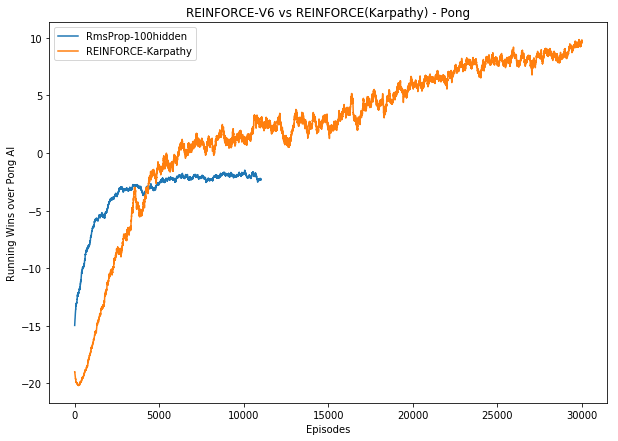

In [5]:
data1 = pickle.load(open('./results/reinforce/pong_100hiddenep=11012history.p', 'rb'))
data2 = pickle.load(open('./results/pg-numpy/reward_history-pg-numpy-30000ep-lr-1e-3.p', 'rb'))

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))


plt.plot(list(range(1,len(data1)+1)), np.array(data1)[:,1], label='RmsProp-100hidden')
plt.plot(list(range(1,len(data2)+1)), np.array(data2)[:,1], label='REINFORCE-Karpathy')
plt.title('REINFORCE-V6 vs REINFORCE(Karpathy) - Pong')
plt.xlabel('Episodes')
plt.ylabel('Running Wins over Pong AI')
plt.legend()
plt.show()